In [1]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
import warnings

warnings.simplefilter('ignore')

### Setup number of processors for multi processing

In [3]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 11 workers


### Read the file

In [4]:
df_news = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 

In [5]:
df_news.head()

date language                                              title  \
0 2021-07-23  english    chicago theater seating chart with seat numbers   
1 2021-07-24  english               harris theater chicago seating chart   
2 2020-12-15  english  There's a Big Tree Growing Through a Car in Il...   
3 2020-03-05  english  Former Fox White House reporter Wendell Goler ...   
4 2020-12-30  english  I am looking forward to many things in 2021. I...   

                                                text  
0  Chicago Theatre Seating Chart With Seat Number...  
1  Harris Theater Seatmap Chicago Opera Theater C...  
2  Published: December 14, 2020 nanjan\nWe're not...  
3  National News FILE - This May 4, 2010 file pho...  
4  I am looking forward to many things in 2021. I...

In [5]:
# we will use 10% of the total articles to get the topics and then train a classifier

df_sample = df_news.sample(frac = 0.1, random_state = 42)

In [7]:
# Sample of data (10%-15%)
# data sample is 10% of data  and prod data is 90% of the data --> how to get the remaining 90% of the data? --> df_remains = df[~df.index.isin(df_sample.index)]
# extract topics from data sample and label the articles --> how to label?
# Train a model (NB or BiGRU, BERT) on data sample for target variable topic --> how to get the features?
# Predict the topics for the remaining 90% of the data --> on what features?
# Combine the 10% and 90% data into a single dataframe
# Read thru the topics and only keep the articles that are most relevant for the project --> lot of manual work
# Run topic modelling again separate different articles based on relevance --> not sure if this step is needed
# Train/Fit the Yelp Model using the Word2Vec embedding for sentiment analysis
# Predict the sentiment for articles using the word2vec embeddings and the Yelp Model on the relevant articles
# Sentiment analysis over time and plot it
# Identify NER 
# Do Sentiment Analysis for NER


### Tokenize text into words and remove punctuation

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df_sample['text'].tolist()        


In [ ]:
data_tokens = list(sent_to_words(data_list))

### Remove Stopwords, Make n-grams and Lemmatize

In [9]:
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['group', 'call', 'investigate', 'chicago_police_officer', 'group', 'include', 'call', 'doj', 'investigate', 'circumstance', 'lead', 'result', 'group', 'stronger_policie', 'regard', 'car', 'chase', 'clear', 'training', 'guideline', 'police', 'interaction', 'trust', 'say', 'center', 'founder', 'objective', 'would_send', 'message', 'community', 'time', 'different', 'add', 'investigate', 'work', 'jauregui', 'dollar', 'help', 'neighborhood', 'suggest', 'add', 'worker', 'school', 'support', 'say', 'traumatize', 'jauregui', 'call', 'adam', 'year_old', 'live', 'die', 'night', 'shoot', 'release', 'say', 'step', 'investigate', 'praise', 'coalition', 'lawyer', 'community_leader', 'emphasize', 'need', 'invest', 'resource', 'chicago_predominantly', 'latino', 'school', 'community', 'leader', 'call', 'increased_investment', 'community', 'city', 'prosper', 'neighborhood', 'early', 'call', 'call', 'thorough', 'expeditious', 'investigation', 'shooting', 'change', 'chicago_police', 'foot_pursuit_policie

In [12]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

### Tune LDA model

In [13]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

### Hyperparameter Tuning:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

In [14]:
def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [15]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 80
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
alpha = []
#alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

LDA will execute 79 iterations
Completed model based on 2 LDA topics. Finished 1.3% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:37sec
Completed model based on 3 LDA topics. Finished 2.5% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:40sec
Completed model based on 4 LDA topics. Finished 3.8% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:41sec
Completed model based on 5 LDA topics. Finished 5.1% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:43sec
Completed model based on 6 LDA topics. Finished 6.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:43sec
Completed model based on 7 LDA topics. Finished 7.6% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:45sec
Completed model based on 8 LDA topics. Finished 8.9% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:46sec
Completed model based on 9 LDA topics. Finished 10.1% of LDA runs
Execution time to calculate for topic 9: 0

Completed model based on 68 LDA topics. Finished 84.8% of LDA runs
Execution time to calculate for topic 68: 0hour:2min:36sec
Completed model based on 69 LDA topics. Finished 86.1% of LDA runs
Execution time to calculate for topic 69: 0hour:2min:39sec
Completed model based on 70 LDA topics. Finished 87.3% of LDA runs
Execution time to calculate for topic 70: 0hour:2min:41sec
Completed model based on 71 LDA topics. Finished 88.6% of LDA runs
Execution time to calculate for topic 71: 0hour:2min:44sec
Completed model based on 72 LDA topics. Finished 89.9% of LDA runs
Execution time to calculate for topic 72: 0hour:2min:42sec
Completed model based on 73 LDA topics. Finished 91.1% of LDA runs
Execution time to calculate for topic 73: 0hour:2min:45sec
Completed model based on 74 LDA topics. Finished 92.4% of LDA runs
Execution time to calculate for topic 74: 0hour:2min:46sec
Completed model based on 75 LDA topics. Finished 93.7% of LDA runs
Execution time to calculate for topic 75: 0hour:2mi

In [16]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

Topics       Alpha  Beta  Coherence
3        5  asymmetric  auto   0.437097
4        6  asymmetric  auto   0.428483
5        7  asymmetric  auto   0.426970
6        8  asymmetric  auto   0.411404
7        9  asymmetric  auto   0.406447
35      37  asymmetric  auto   0.404223
37      39  asymmetric  auto   0.403777
68      70  asymmetric  auto   0.402880
45      47  asymmetric  auto   0.402876
22      24  asymmetric  auto   0.401604

In [17]:
# Worst LDA parameters
lda_tuning.sort_values(by=['Coherence']).head(10)

Topics       Alpha  Beta  Coherence
2        4  asymmetric  auto   0.331535
1        3  asymmetric  auto   0.334742
0        2  asymmetric  auto   0.339790
13      15  asymmetric  auto   0.369817
14      16  asymmetric  auto   0.370961
17      19  asymmetric  auto   0.371138
16      18  asymmetric  auto   0.372271
15      17  asymmetric  auto   0.376351
75      77  asymmetric  auto   0.377615
11      13  asymmetric  auto   0.377964

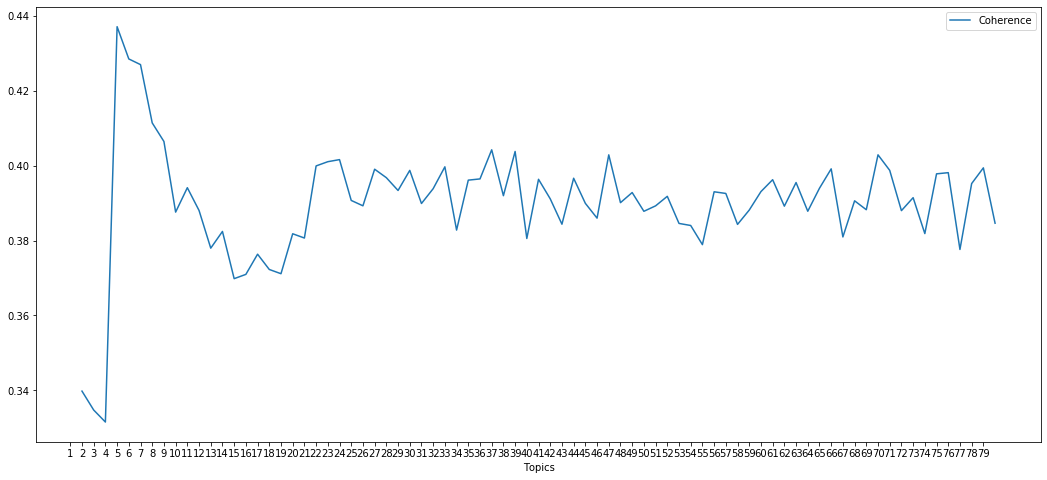

In [24]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,80), figsize = (18,8))

### Running best model

In [25]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 5, Alpha: asymmetric, Beta: auto


### Run the model again with best parameters

In [50]:
tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       #num_topics=tuned_topics,
                       num_topics=50,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda)


Coherence Score:  Coherence_Measure(seg=<function s_one_set at 0x00000297202FA1F8>, prob=<function p_boolean_sliding_window at 0x00000297202FAEE8>, conf=<function cosine_similarity at 0x00000297203B8CA8>, aggr=<function arithmetic_mean at 0x00000297203B8C18>)


In [51]:
tuned_lda_model.print_topics()

[(49,
  '0.009*"say" + 0.005*"work" + 0.005*"use" + 0.005*"church" + 0.004*"community" + 0.004*"university" + 0.004*"serve" + 0.003*"time" + 0.003*"student" + 0.003*"provide"'),
 (48,
  '0.007*"loan" + 0.004*"say" + 0.004*"make" + 0.004*"find" + 0.003*"work" + 0.003*"need" + 0.003*"time" + 0.003*"also" + 0.003*"event" + 0.003*"company"'),
 (47,
  '0.028*"school" + 0.024*"student" + 0.020*"teacher" + 0.017*"say" + 0.015*"district" + 0.009*"strike" + 0.006*"return" + 0.006*"union" + 0.006*"city" + 0.006*"classroom"'),
 (46,
  '0.005*"essay" + 0.004*"go" + 0.004*"play" + 0.003*"get" + 0.003*"message" + 0.003*"park" + 0.003*"bear" + 0.003*"return" + 0.002*"season" + 0.002*"see"'),
 (45,
  '0.011*"company" + 0.010*"roof" + 0.007*"service" + 0.006*"business" + 0.005*"use" + 0.005*"need" + 0.004*"offer" + 0.004*"provide" + 0.004*"get" + 0.004*"may"'),
 (44,
  '0.013*"sale" + 0.011*"home" + 0.008*"build" + 0.006*"bedroom" + 0.006*"say" + 0.005*"single" + 0.004*"strike" + 0.004*"available" + 0.

In [47]:
tuned_lda_model.num_topics

37

### Top2Vec

In [7]:
from top2vec import Top2Vec

In [8]:
# Create top2vecmodel
t2v_model = Top2Vec(data_list, workers = 11)

2021-12-10 20:23:40,865 - top2vec - INFO - Pre-processing documents for training
2021-12-10 20:23:57,811 - top2vec - INFO - Creating joint document/word embedding
2021-12-10 20:37:05,424 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-10 20:37:31,107 - top2vec - INFO - Finding dense areas of documents
2021-12-10 20:37:33,340 - top2vec - INFO - Finding topics


In [9]:
t2v_model.get_num_topics()

209

In [11]:
topic_sizes, topic_nums = t2v_model.get_topic_sizes()
topic_sizes

array([658, 525, 449, 381, 369, 365, 355, 309, 272, 269, 259, 256, 247,
       238, 236, 228, 215, 205, 204, 204, 203, 196, 193, 191, 185, 183,
       183, 174, 173, 170, 168, 160, 159, 158, 158, 154, 149, 148, 145,
       141, 140, 139, 139, 133, 130, 124, 123, 123, 117, 113, 109, 109,
       107, 105, 101, 101, 101,  99,  99,  98,  96,  93,  92,  92,  91,
        91,  90,  90,  89,  89,  87,  87,  87,  86,  86,  85,  85,  82,
        81,  80,  78,  76,  76,  75,  75,  75,  75,  73,  73,  72,  72,
        72,  71,  70,  69,  67,  67,  66,  65,  64,  64,  64,  62,  62,
        62,  61,  61,  61,  61,  60,  59,  59,  59,  59,  59,  58,  58,
        57,  57,  56,  56,  55,  55,  54,  54,  54,  54,  54,  53,  53,
        52,  52,  51,  51,  51,  51,  51,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  49,  49,  49,  48,  48,  48,  48,  48,  48,  47,
        47,  47,  45,  45,  44,  43,  43,  42,  42,  42,  41,  41,  41,
        41,  41,  41,  40,  40,  40,  39,  39,  38,  38,  38,  3

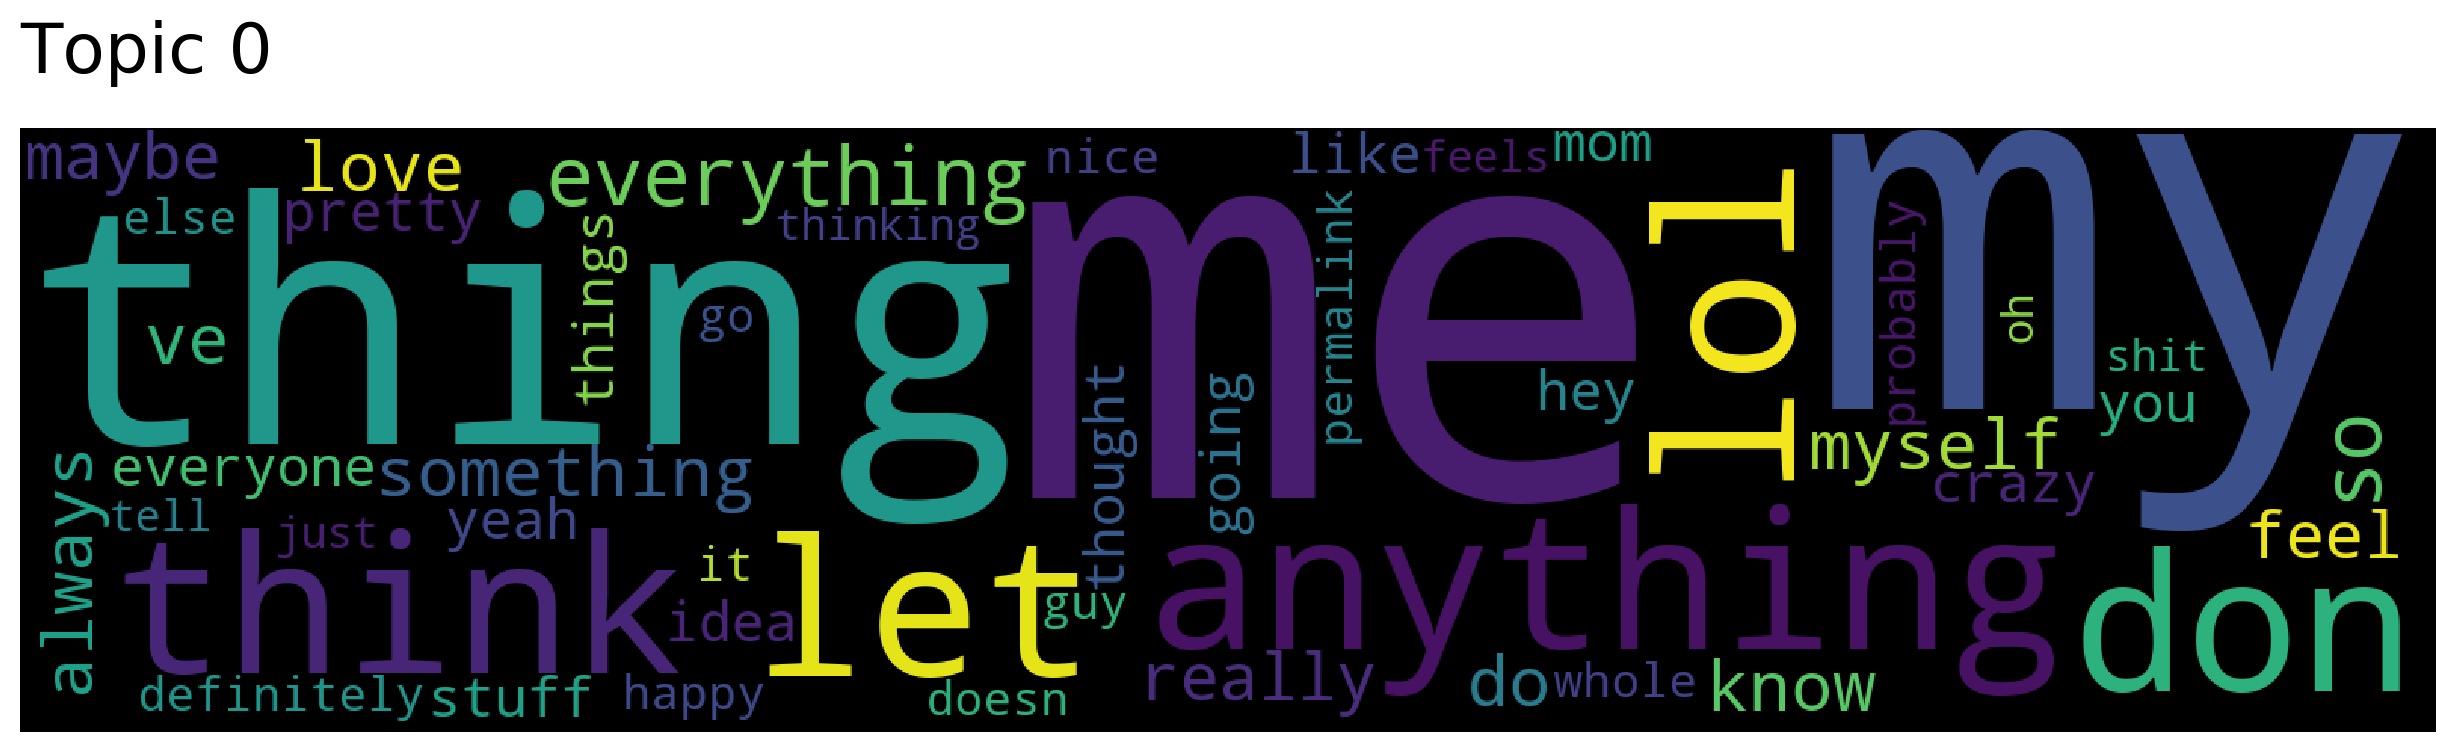

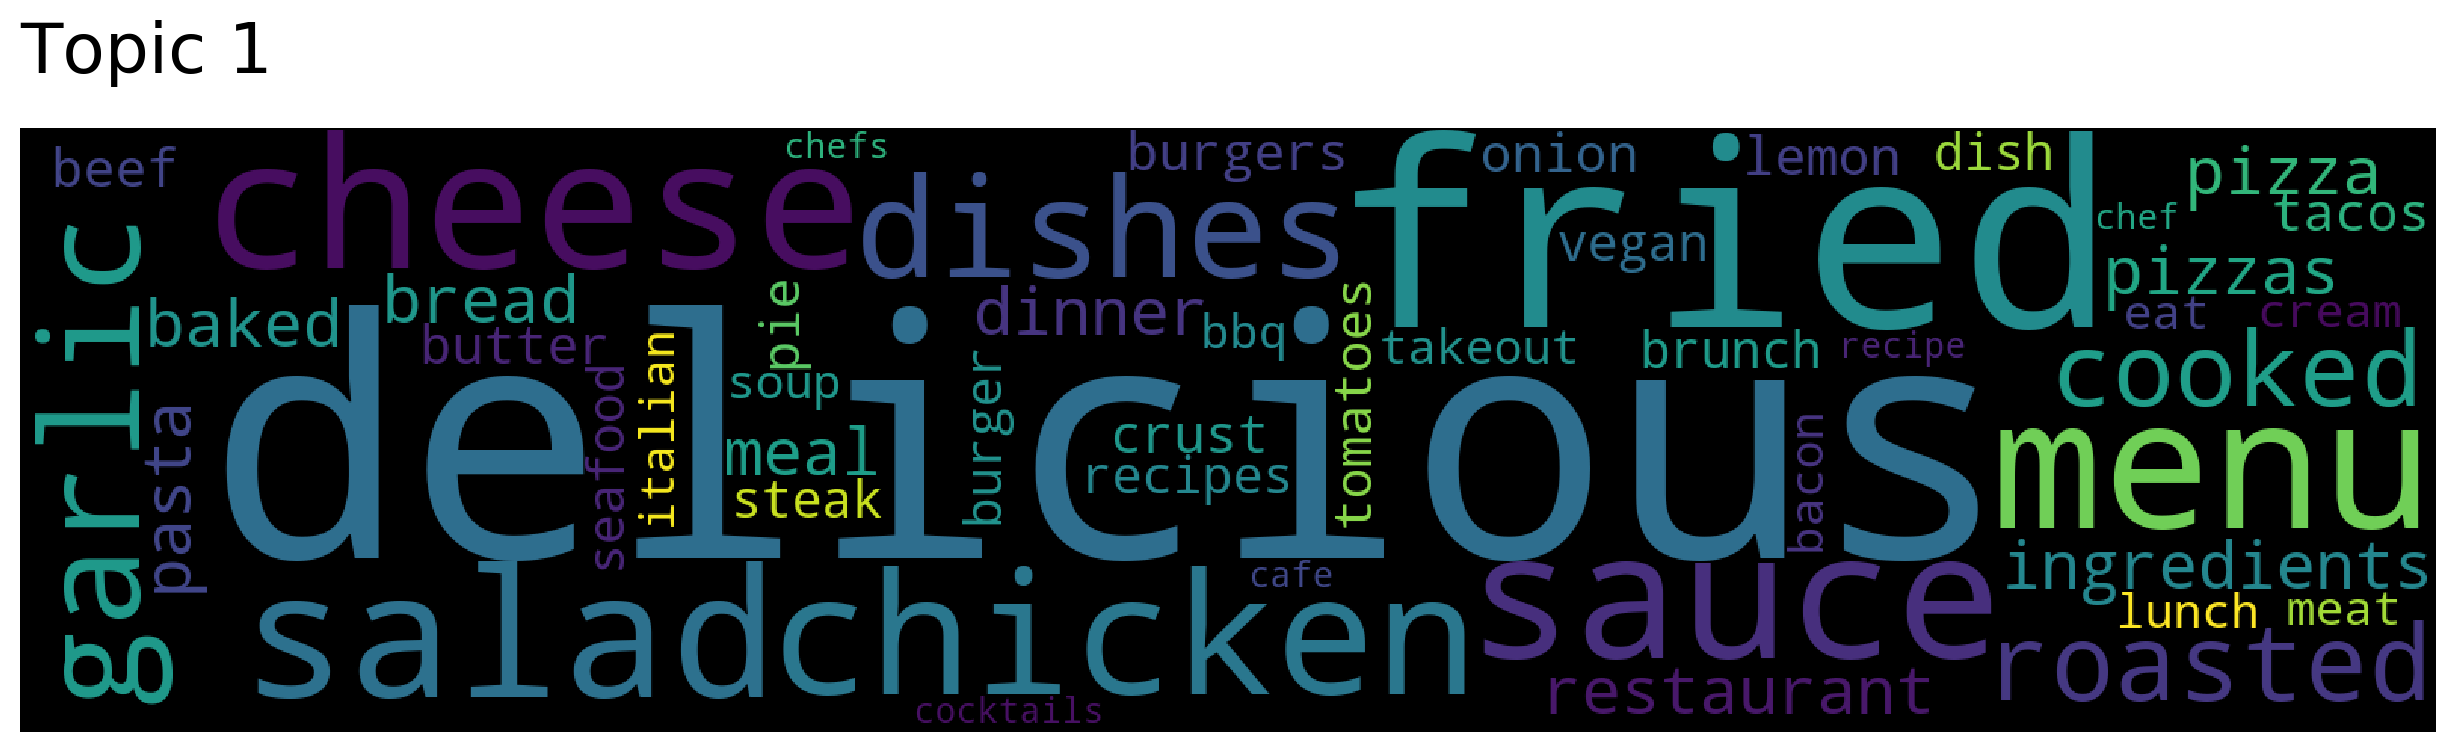

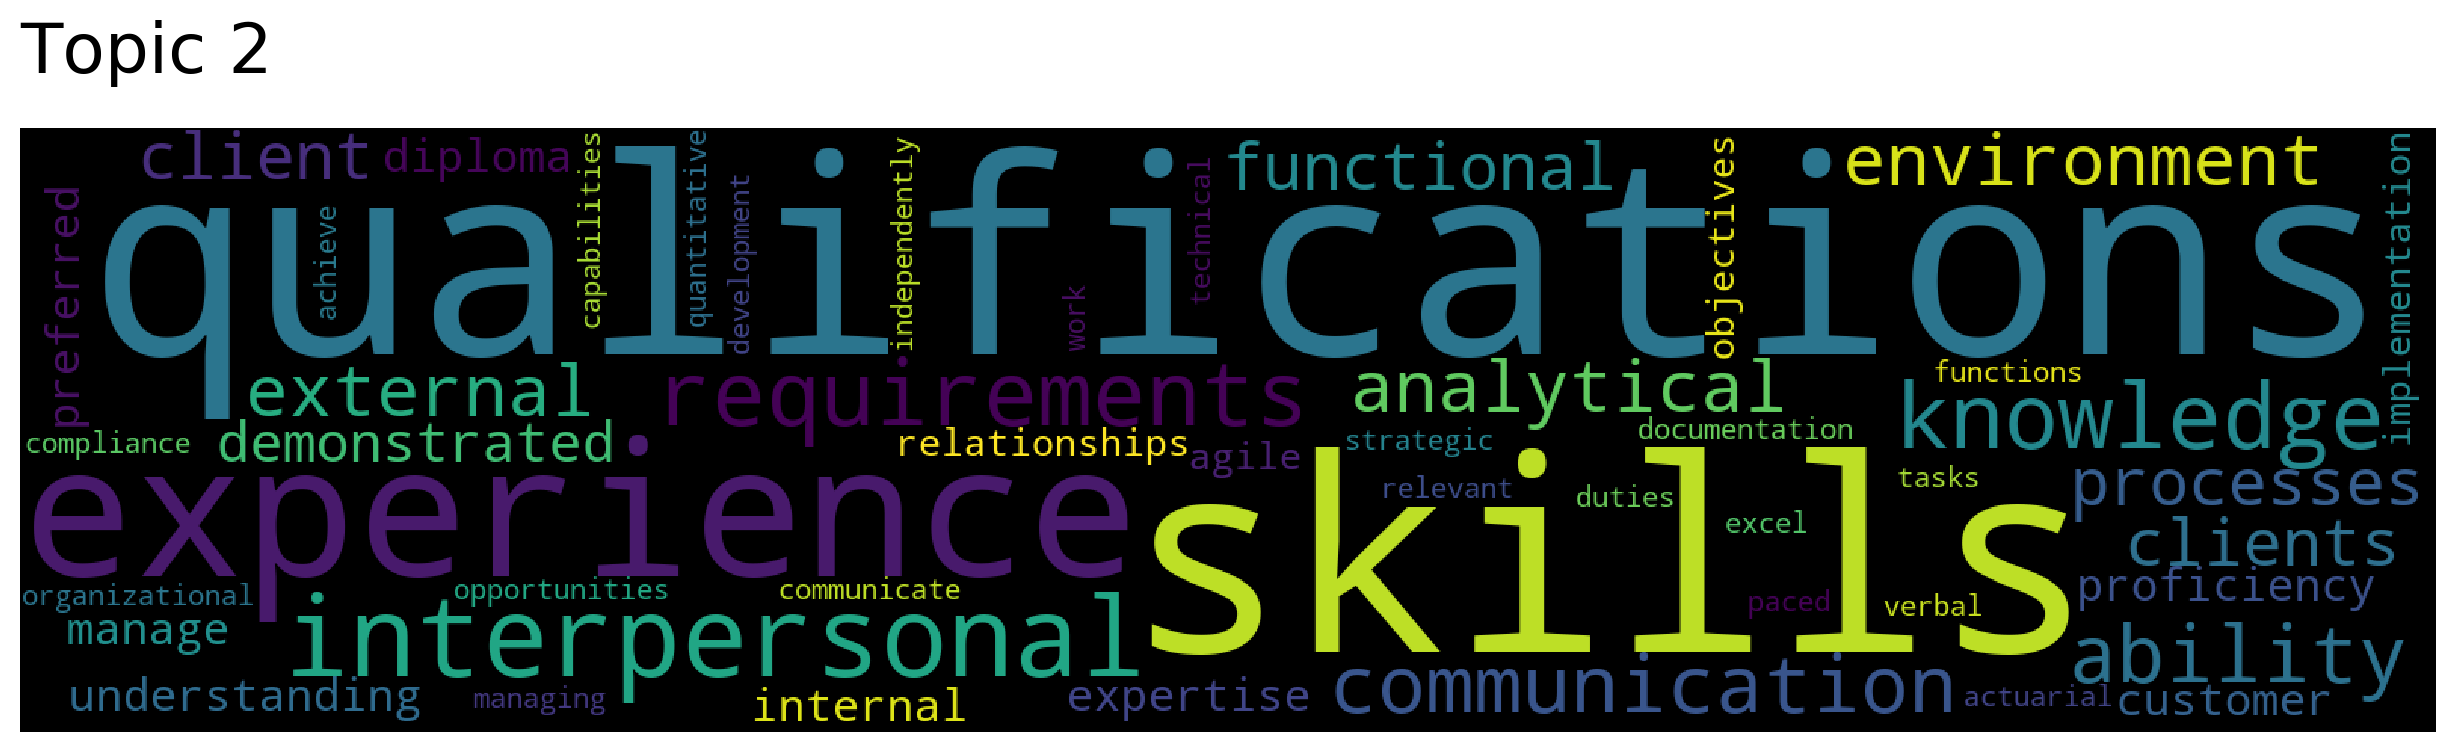

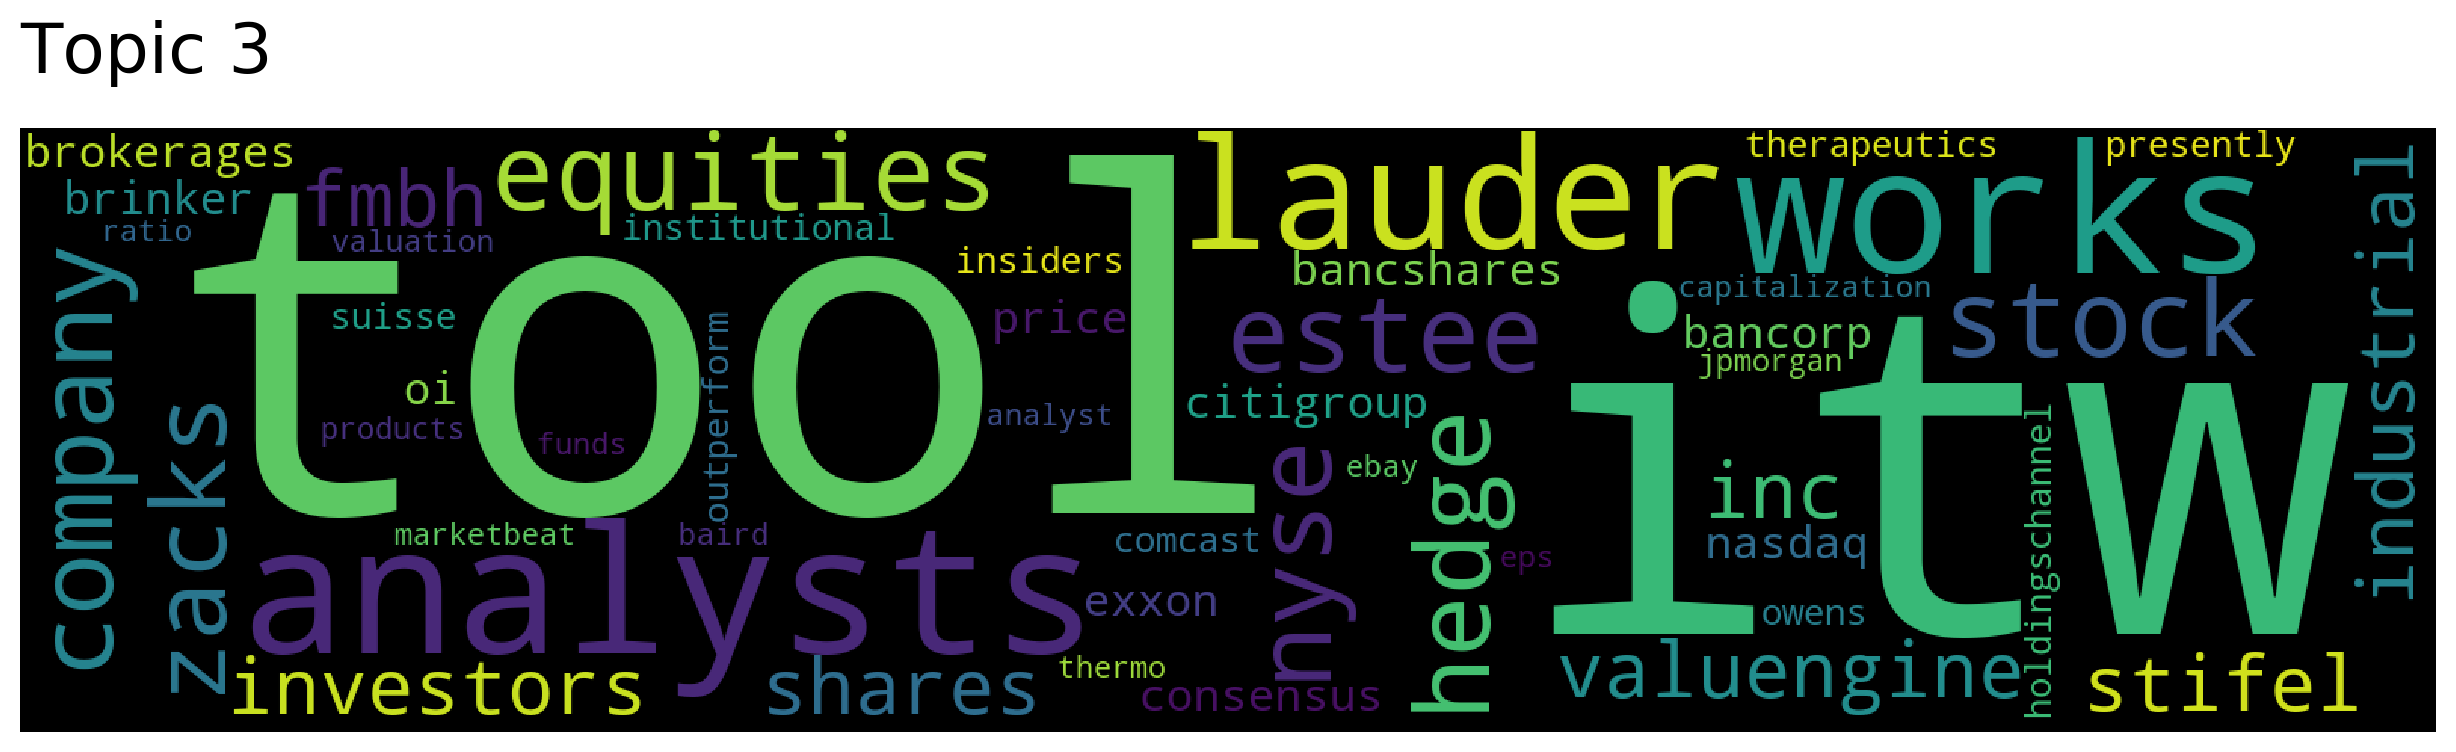

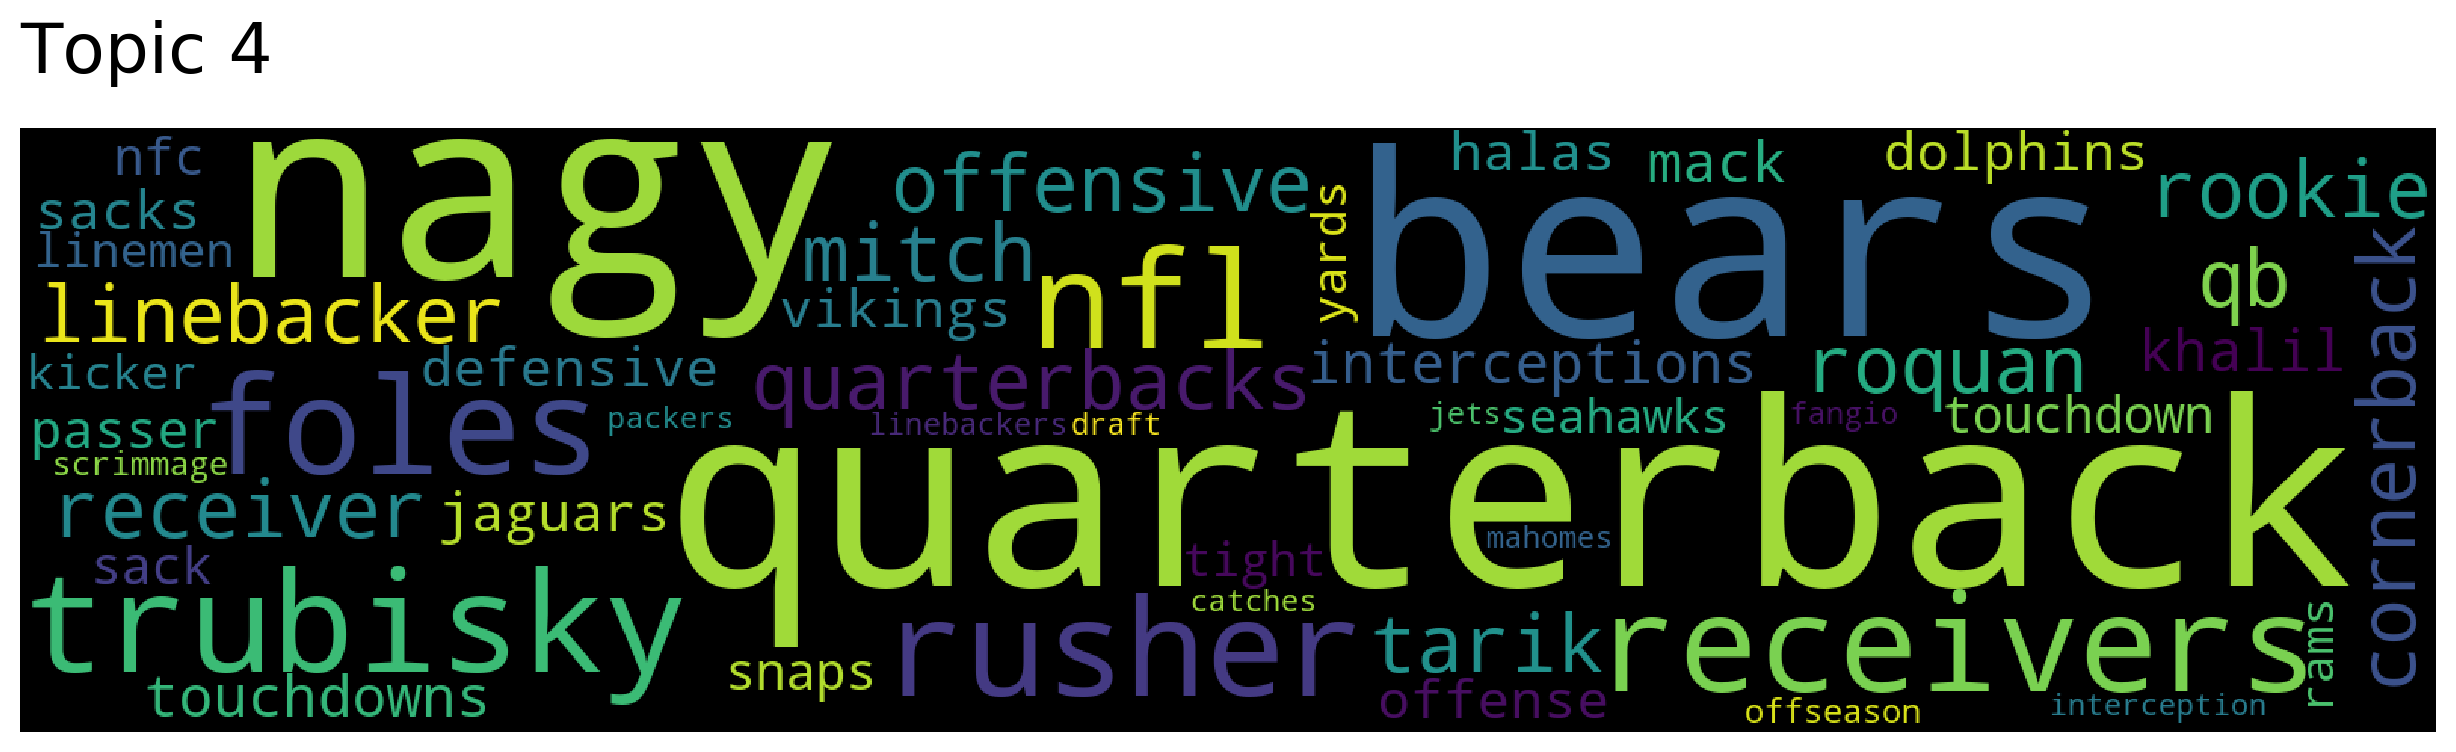

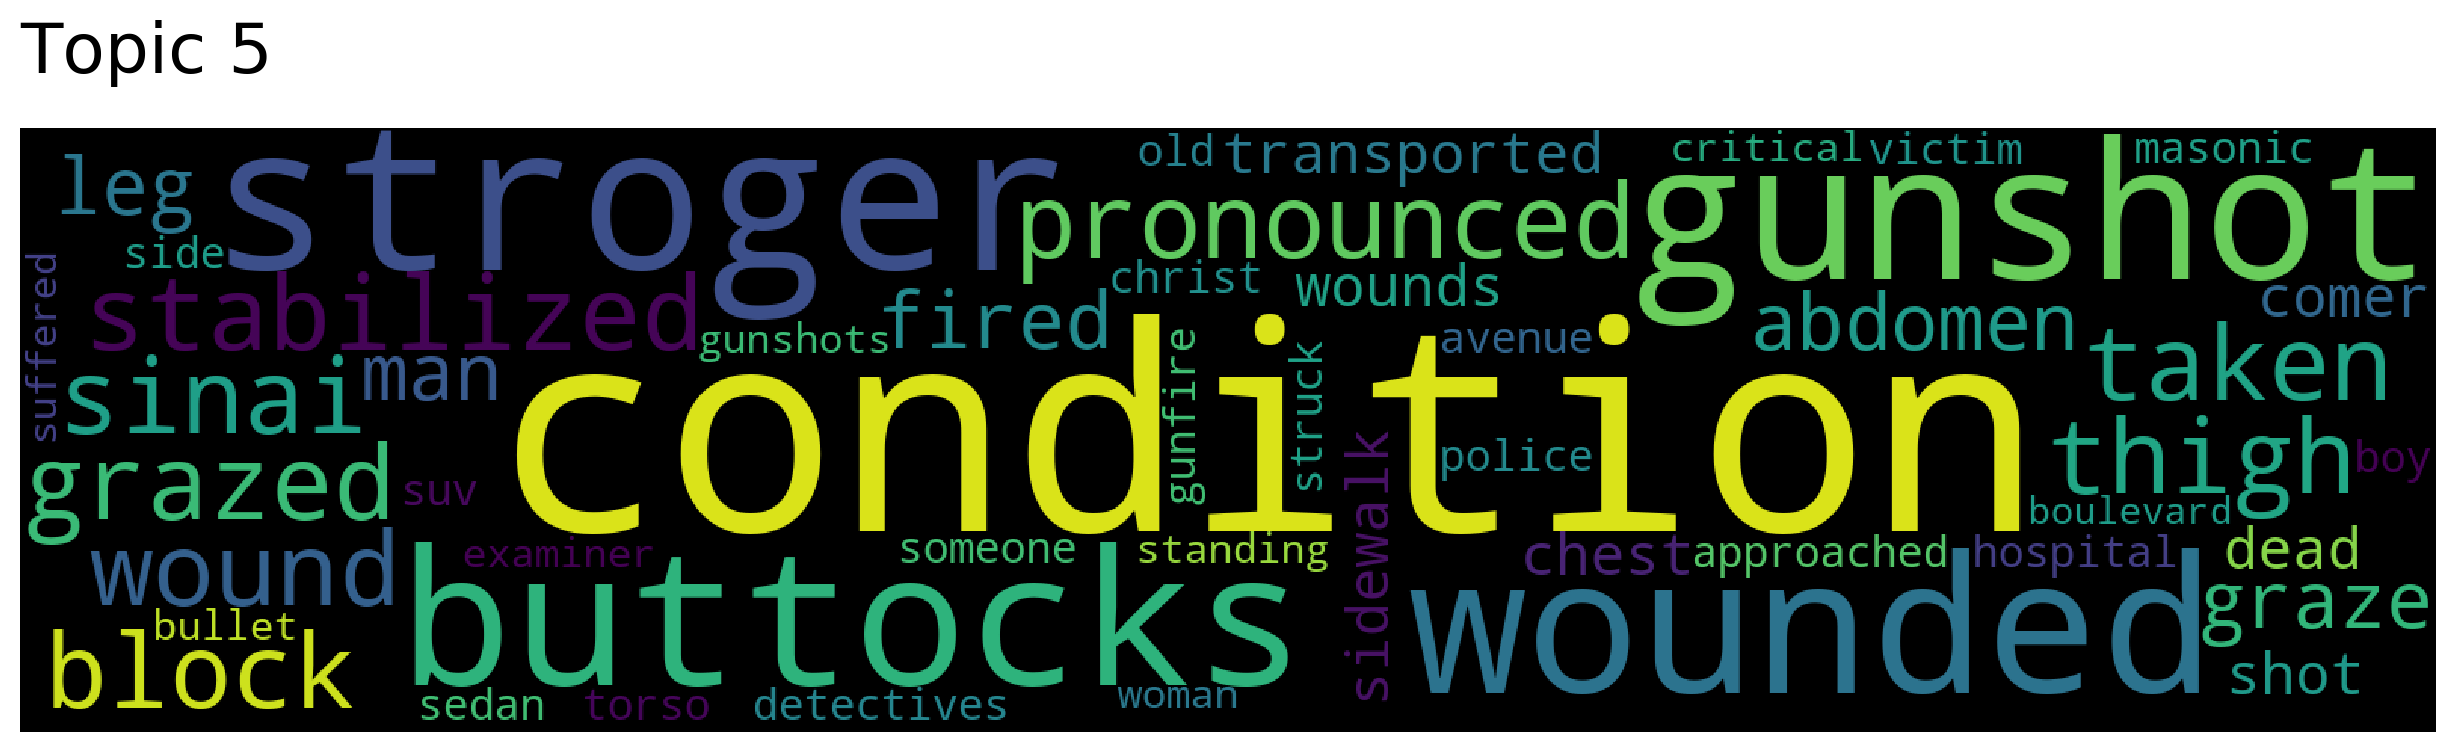

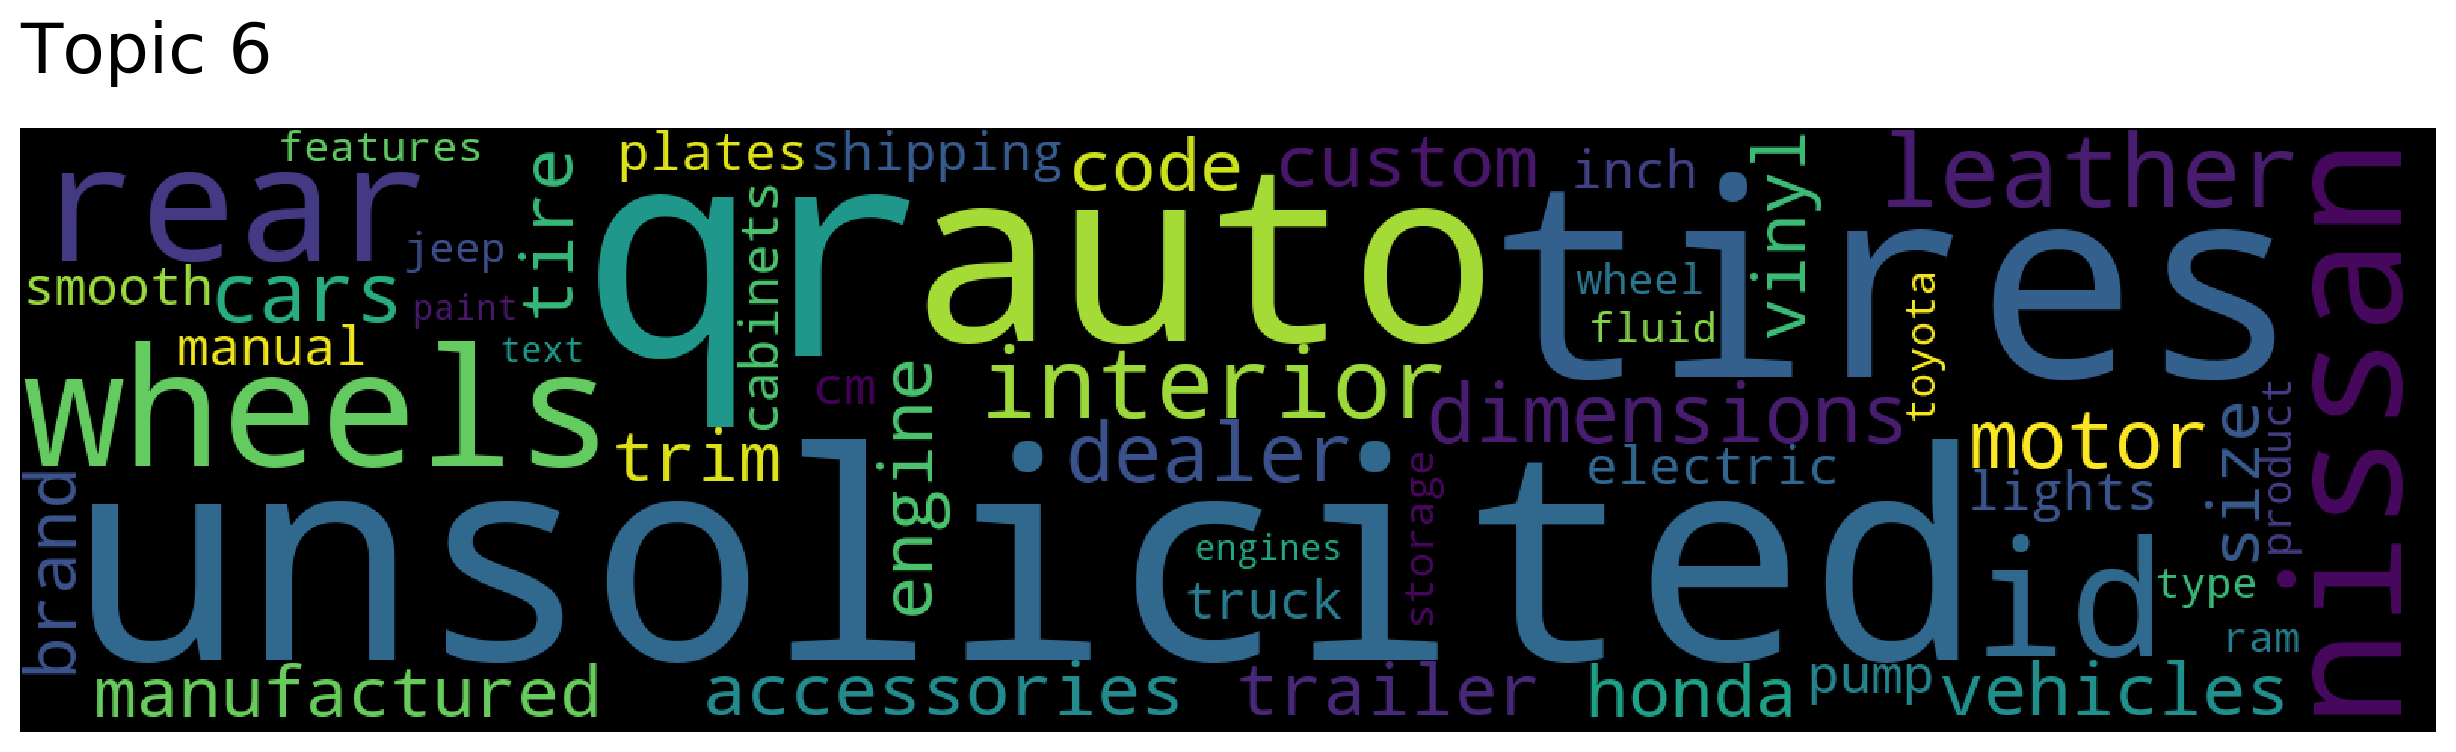

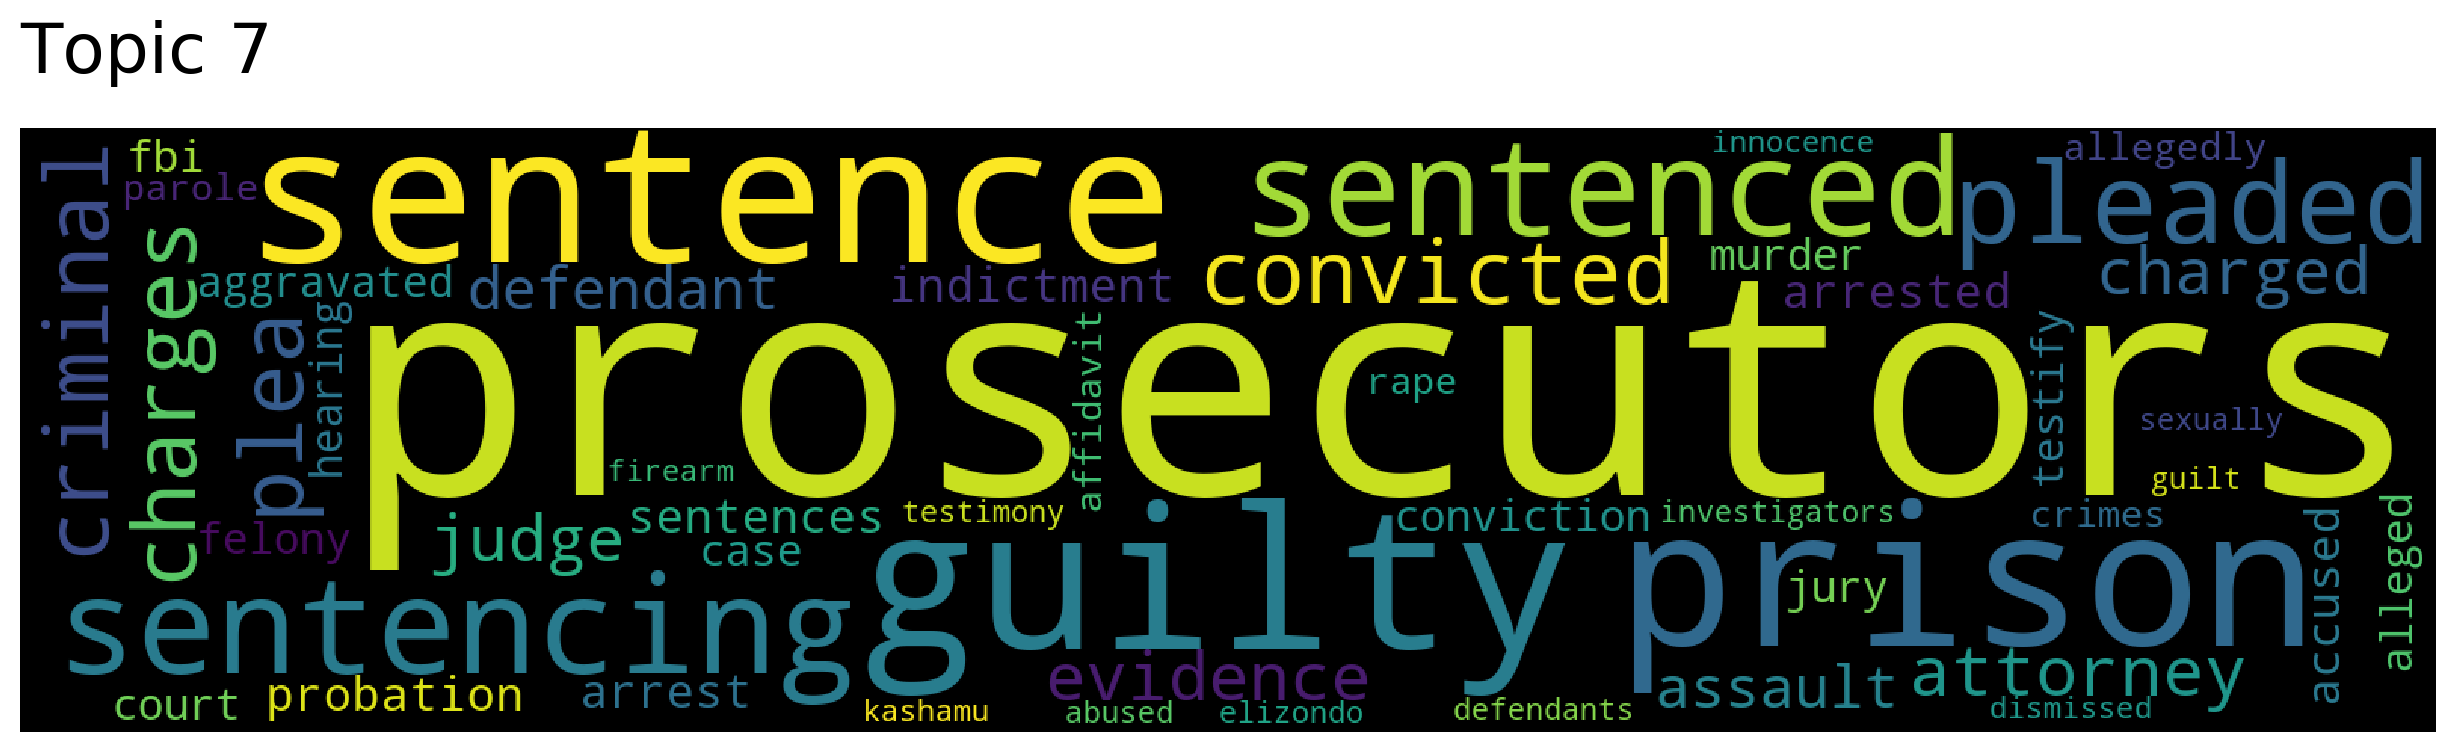

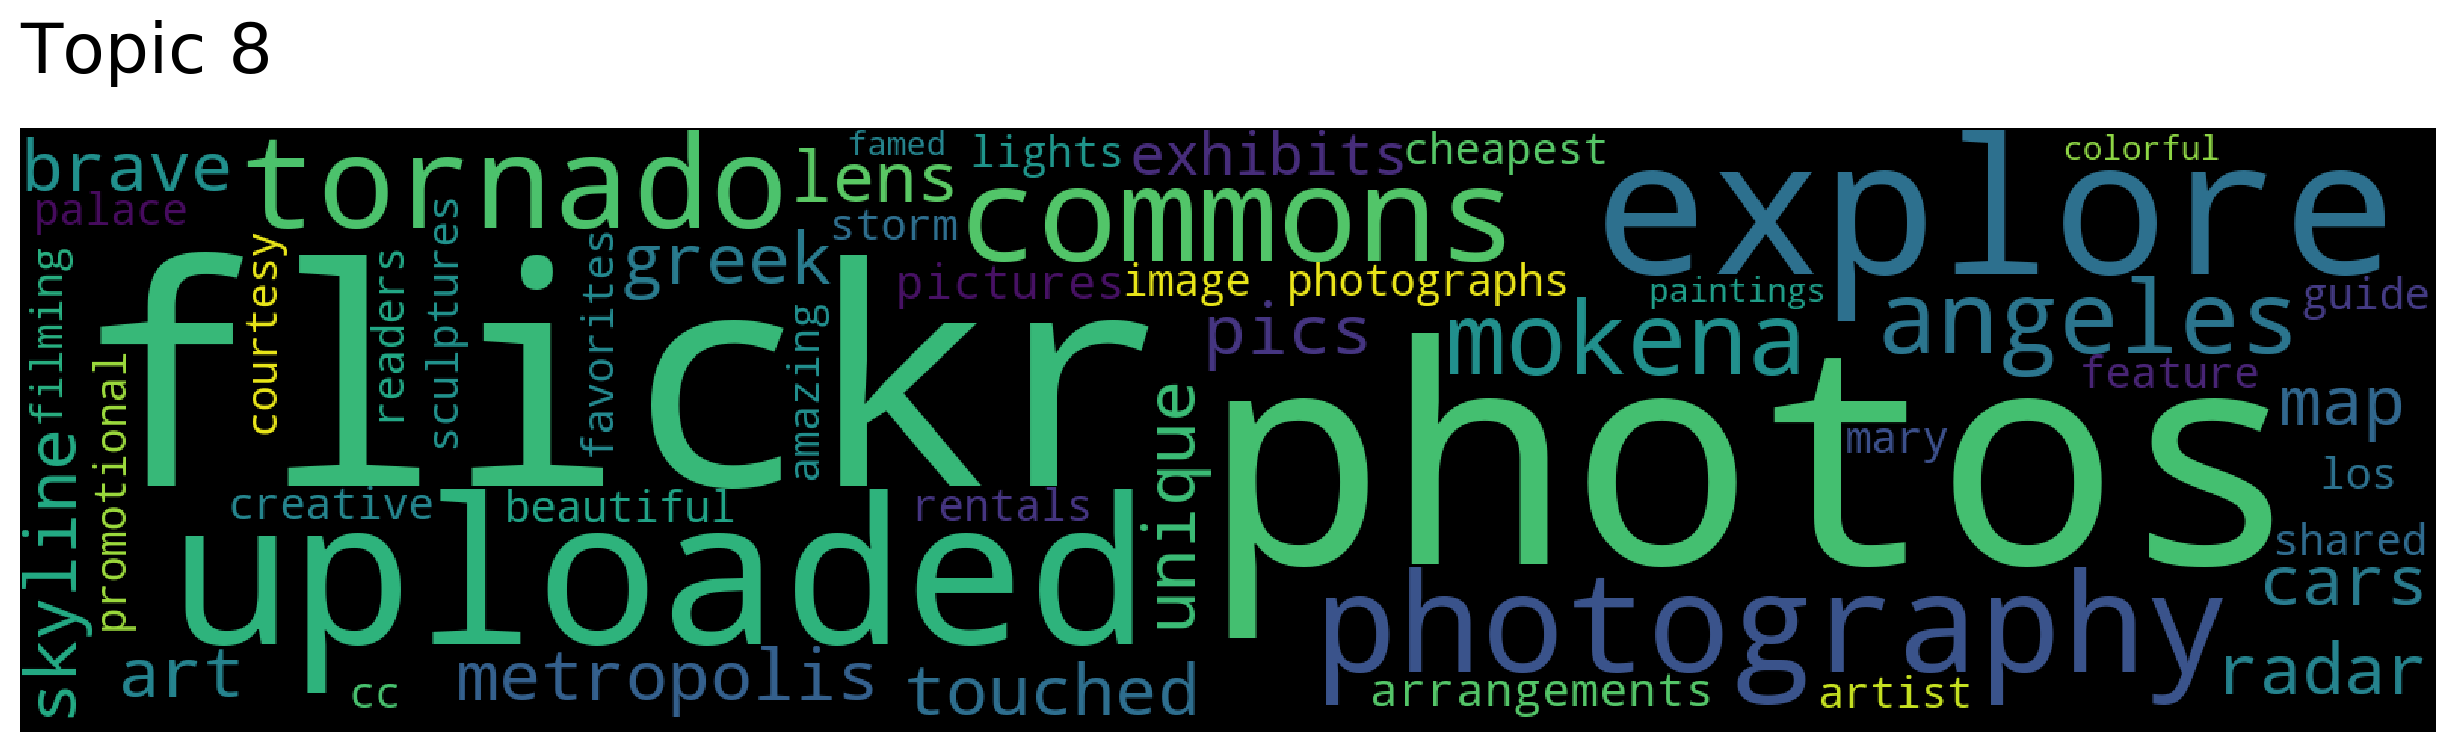

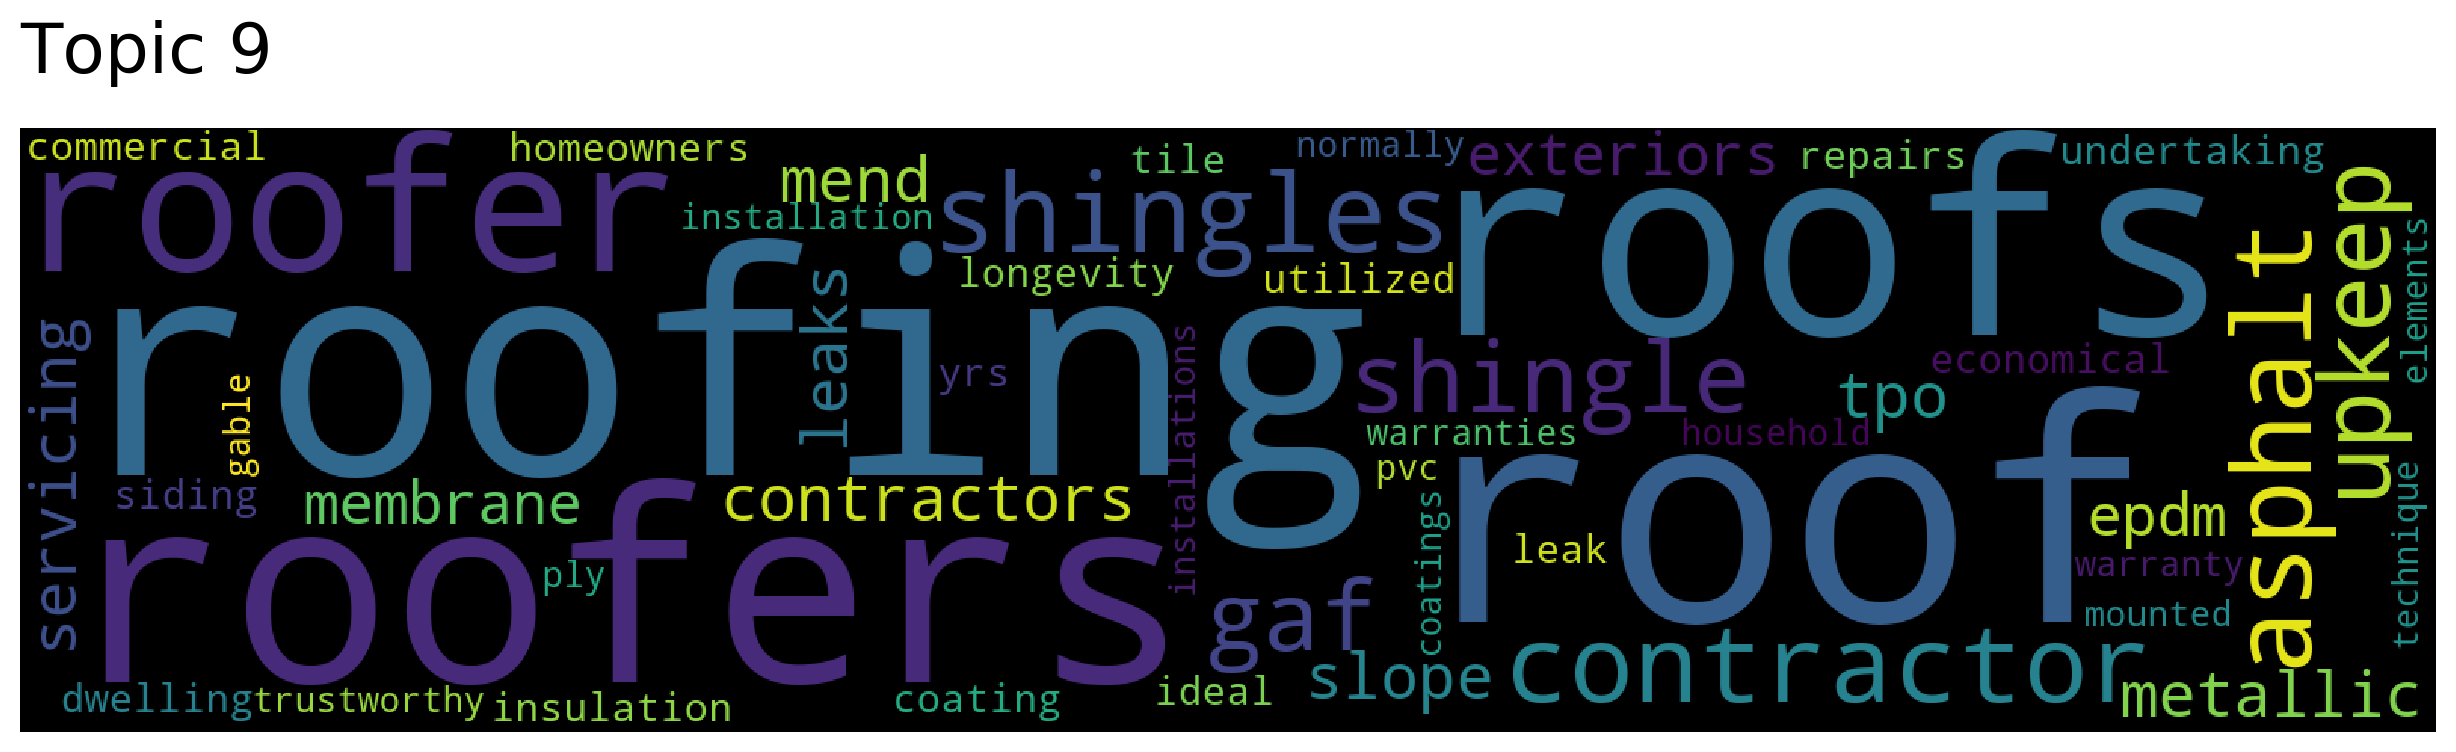

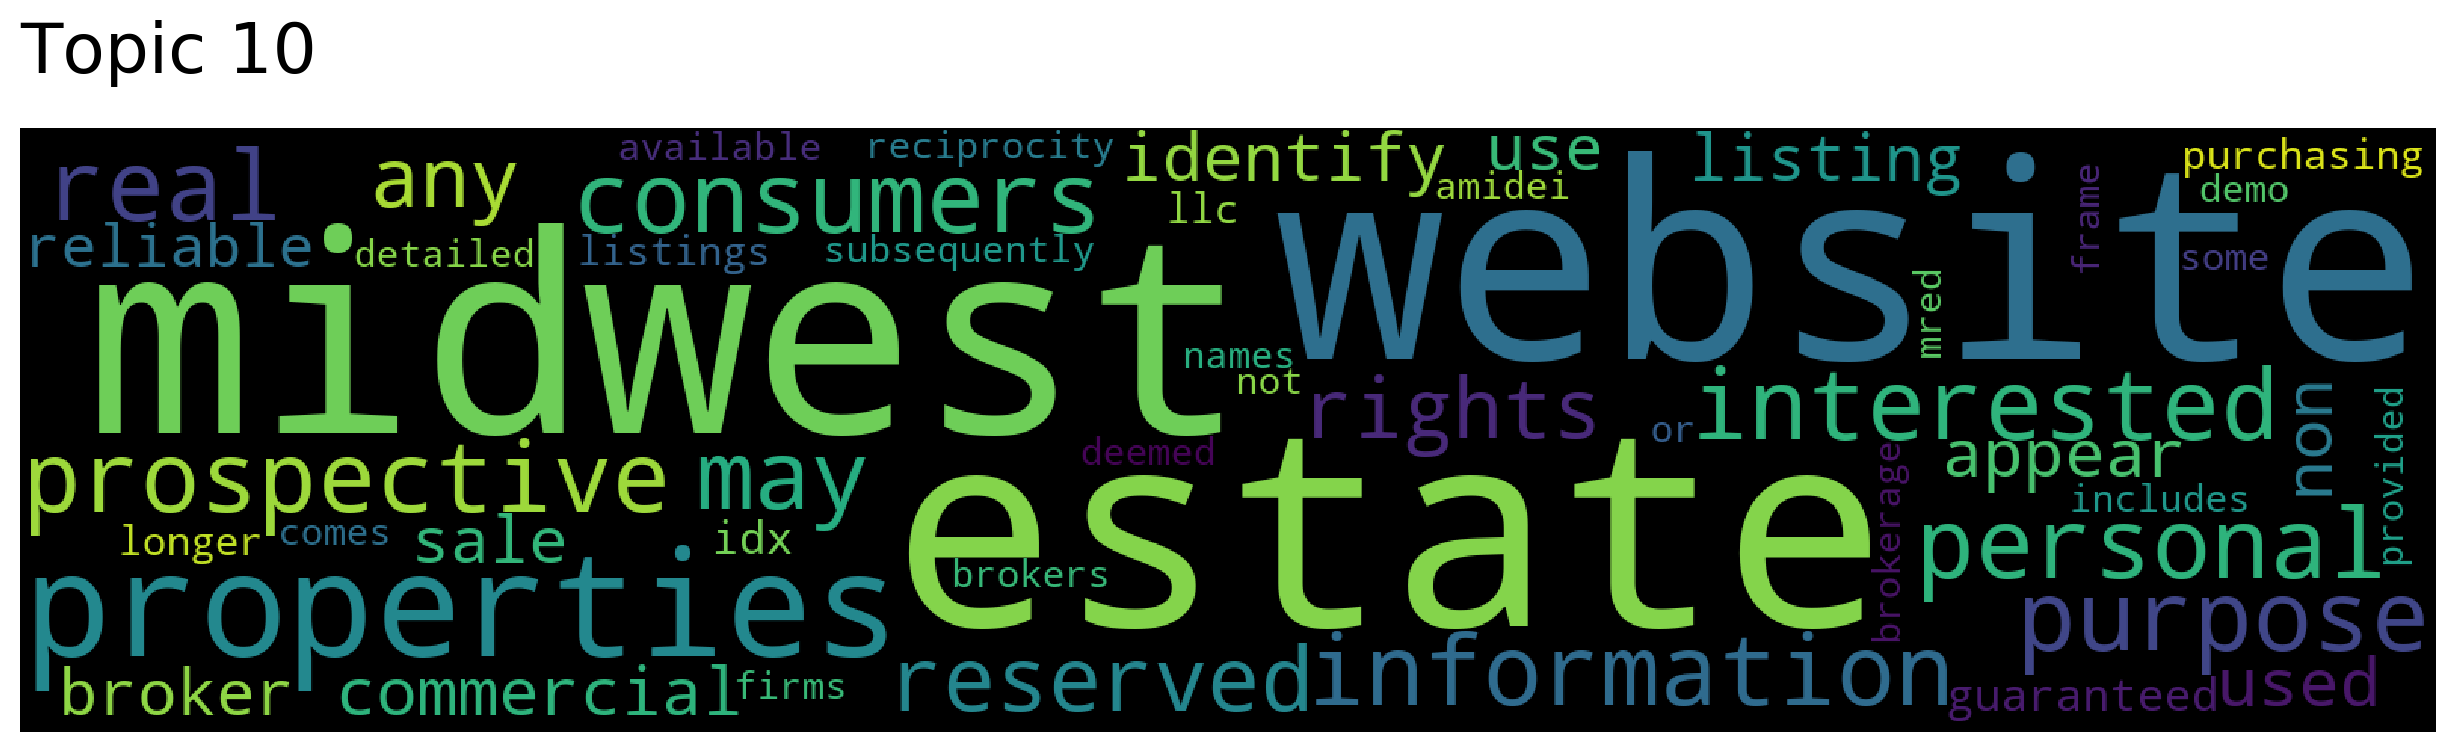

In [12]:
for topic in topic_nums[0:11]:
    t2v_model.generate_topic_wordcloud(topic, background_color="black")

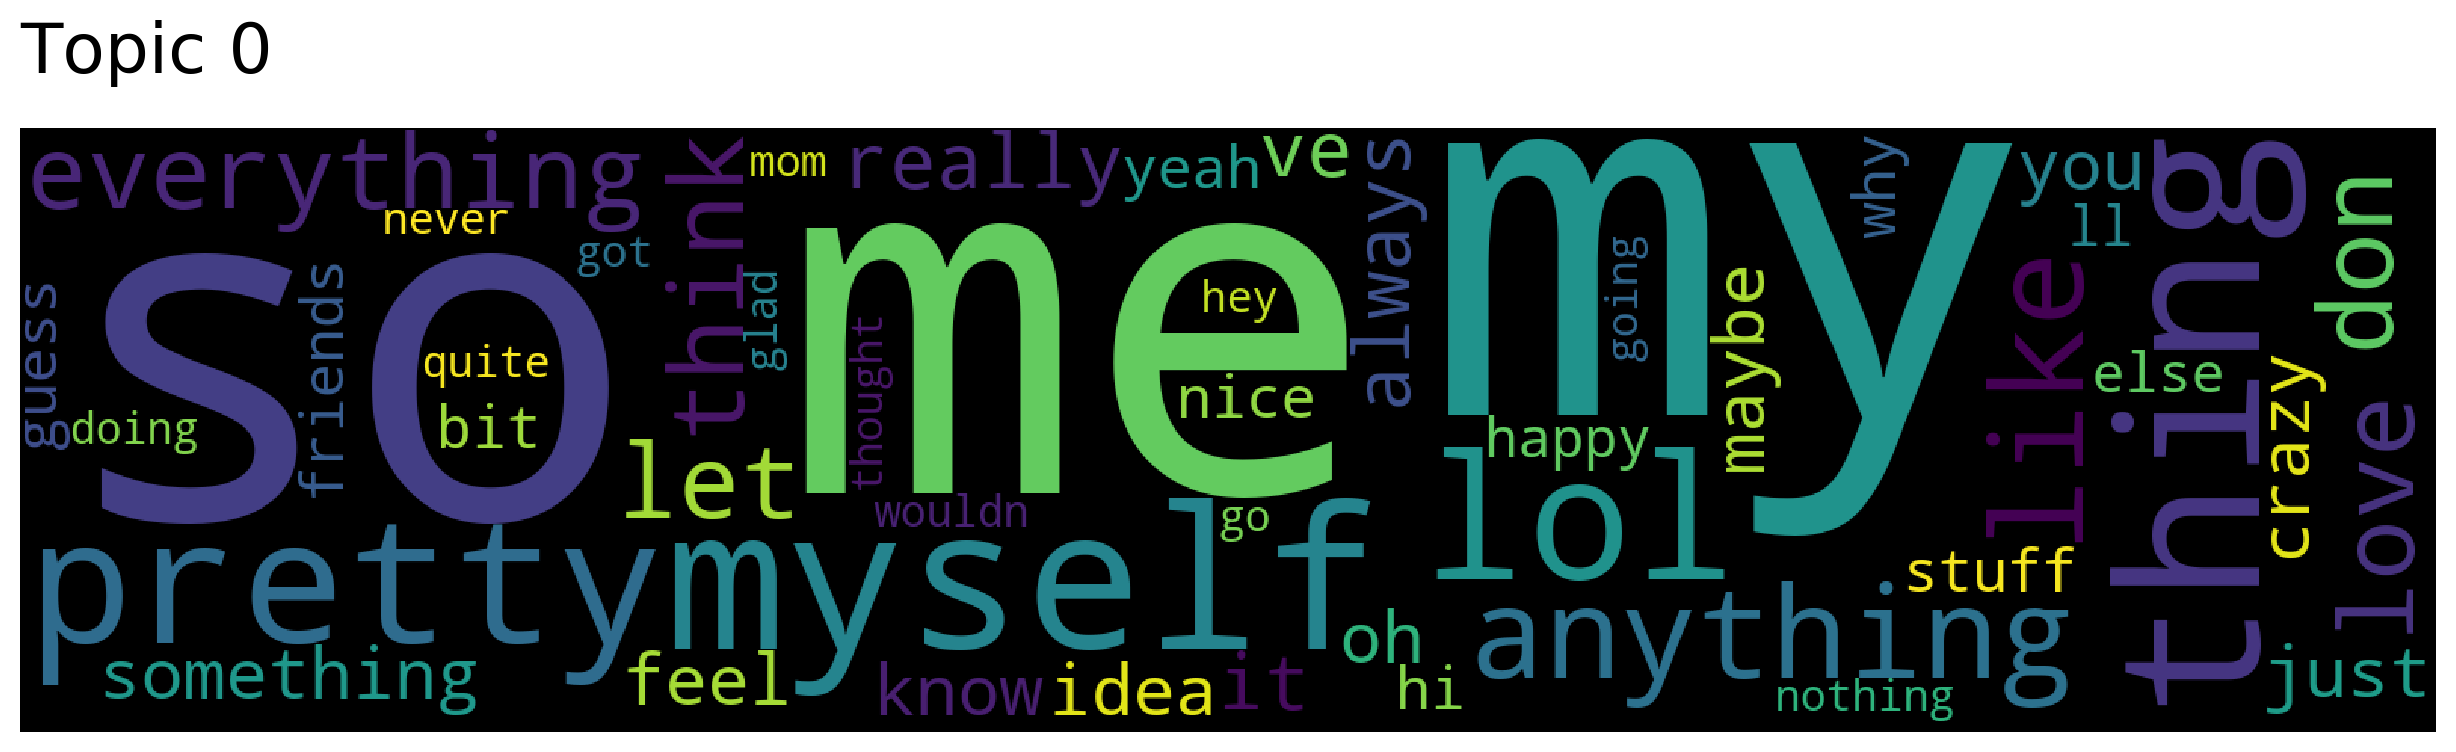

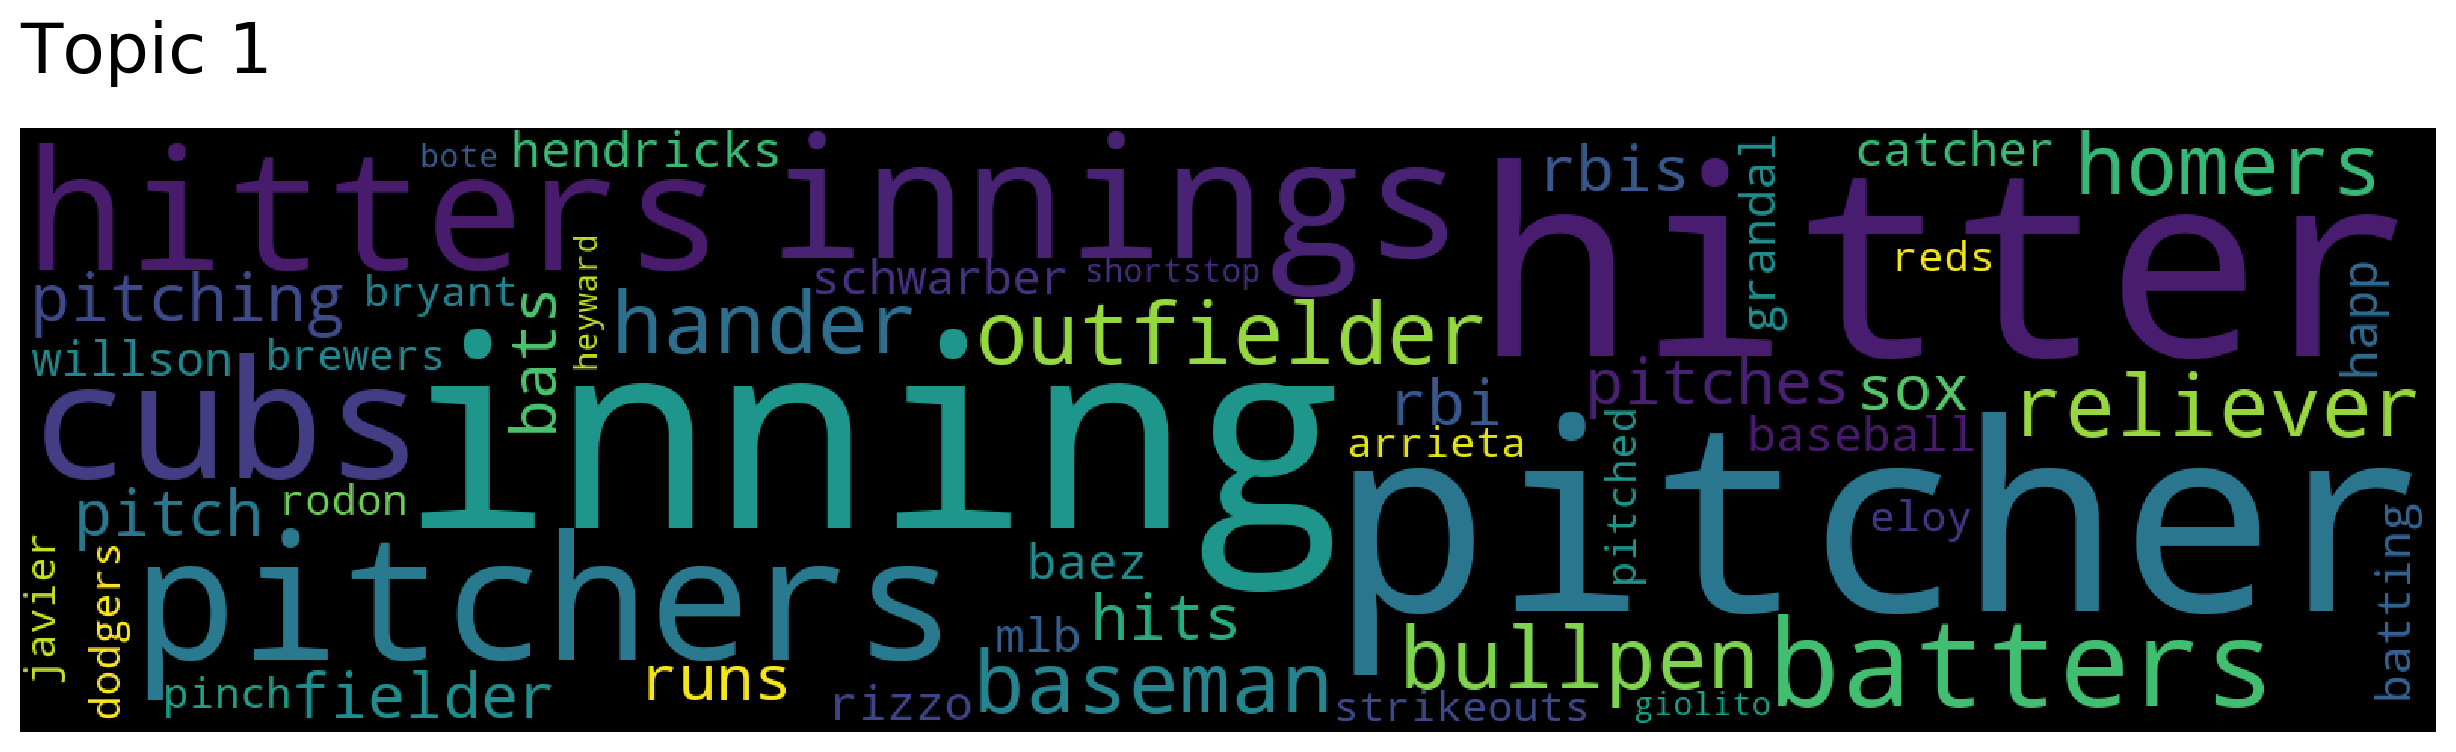

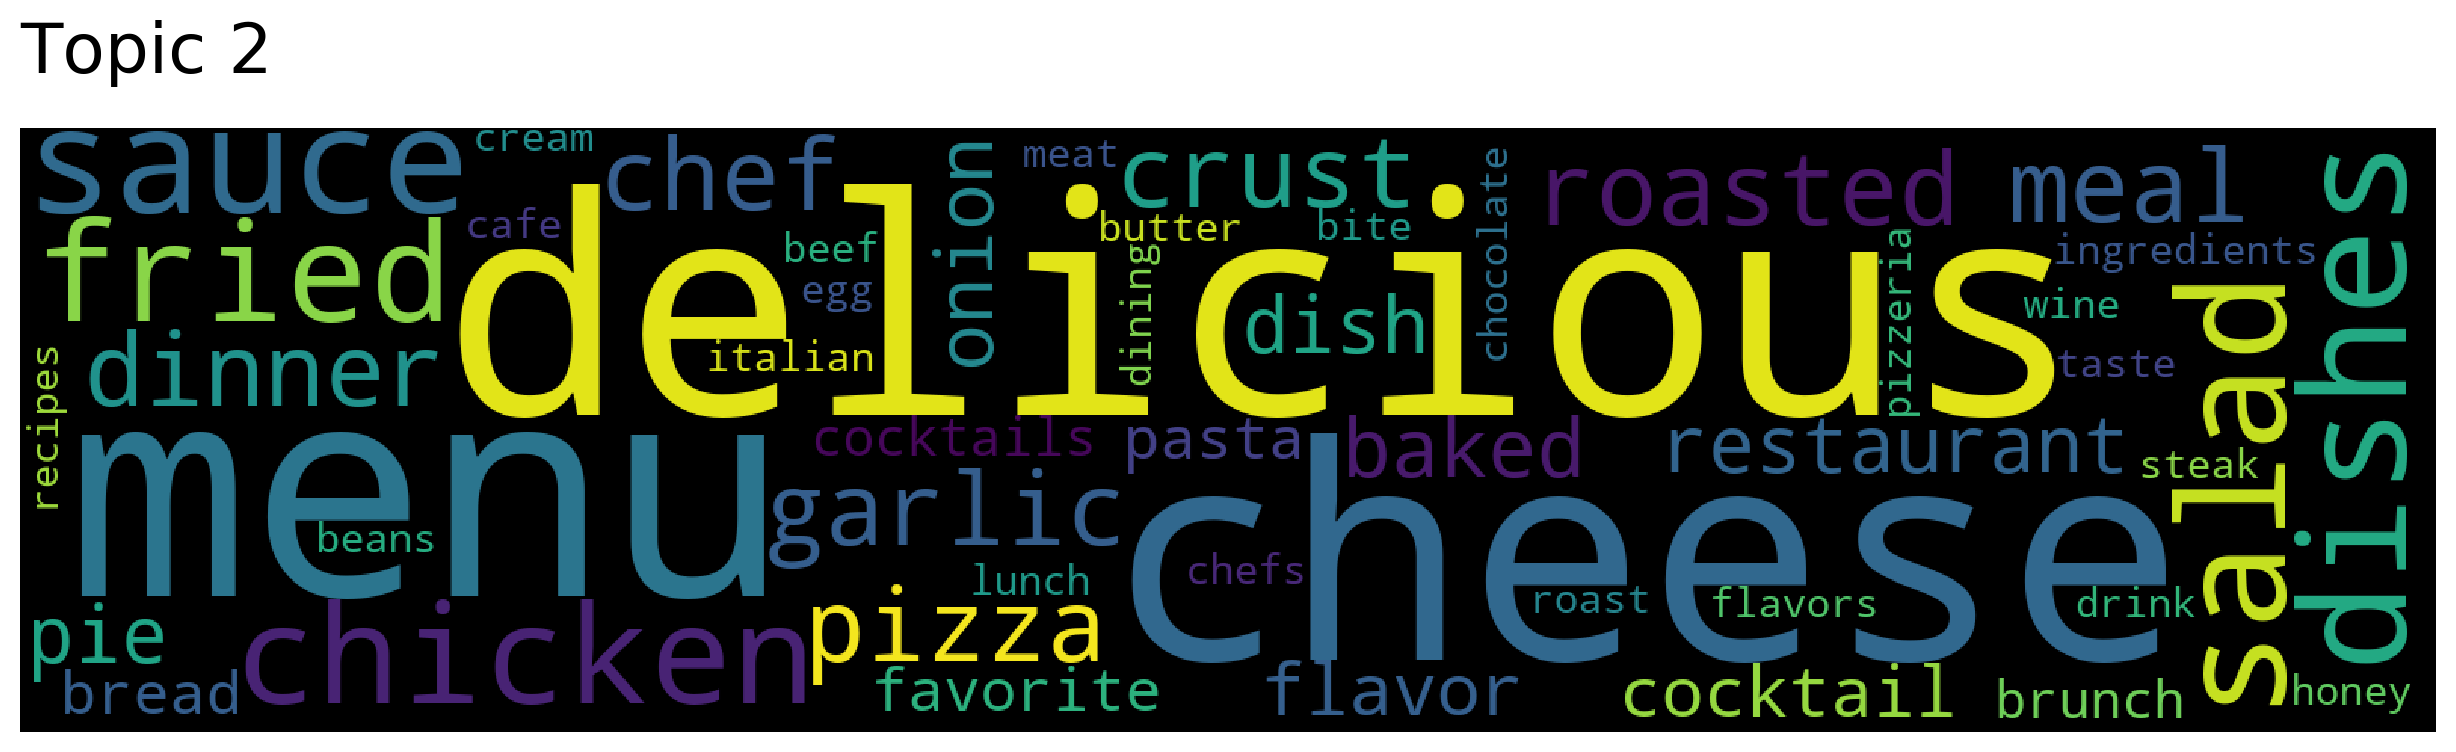

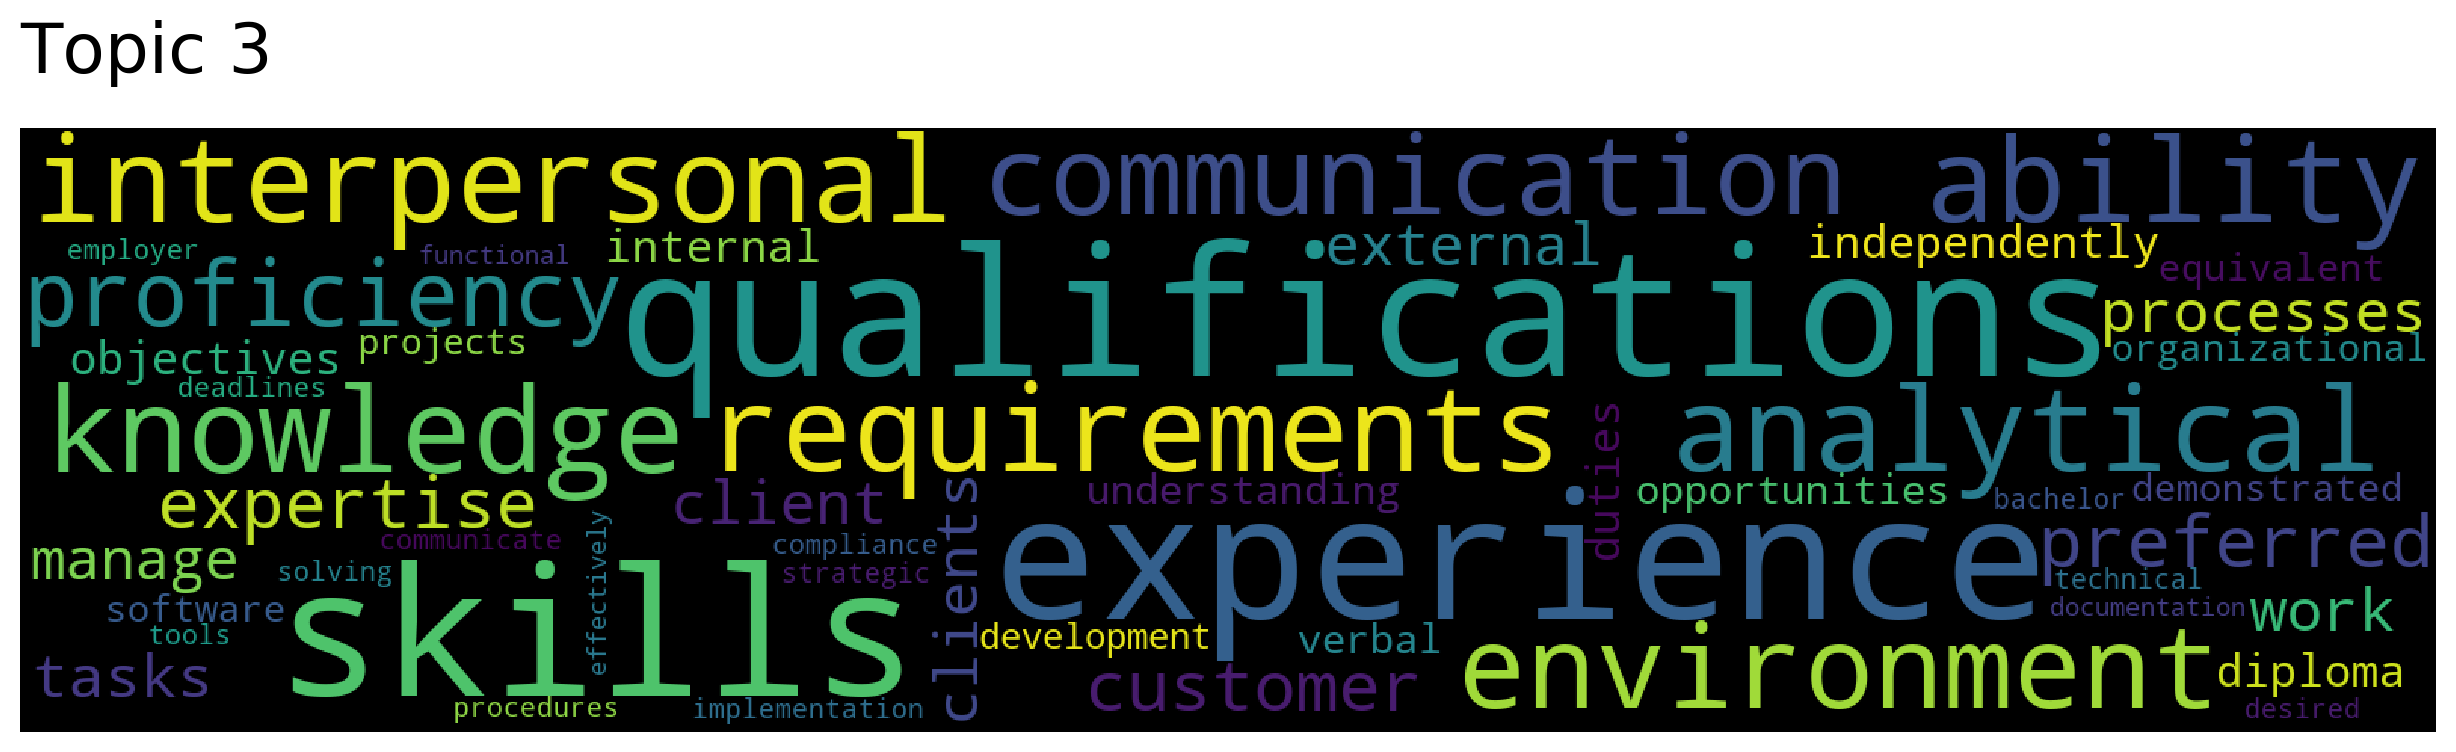

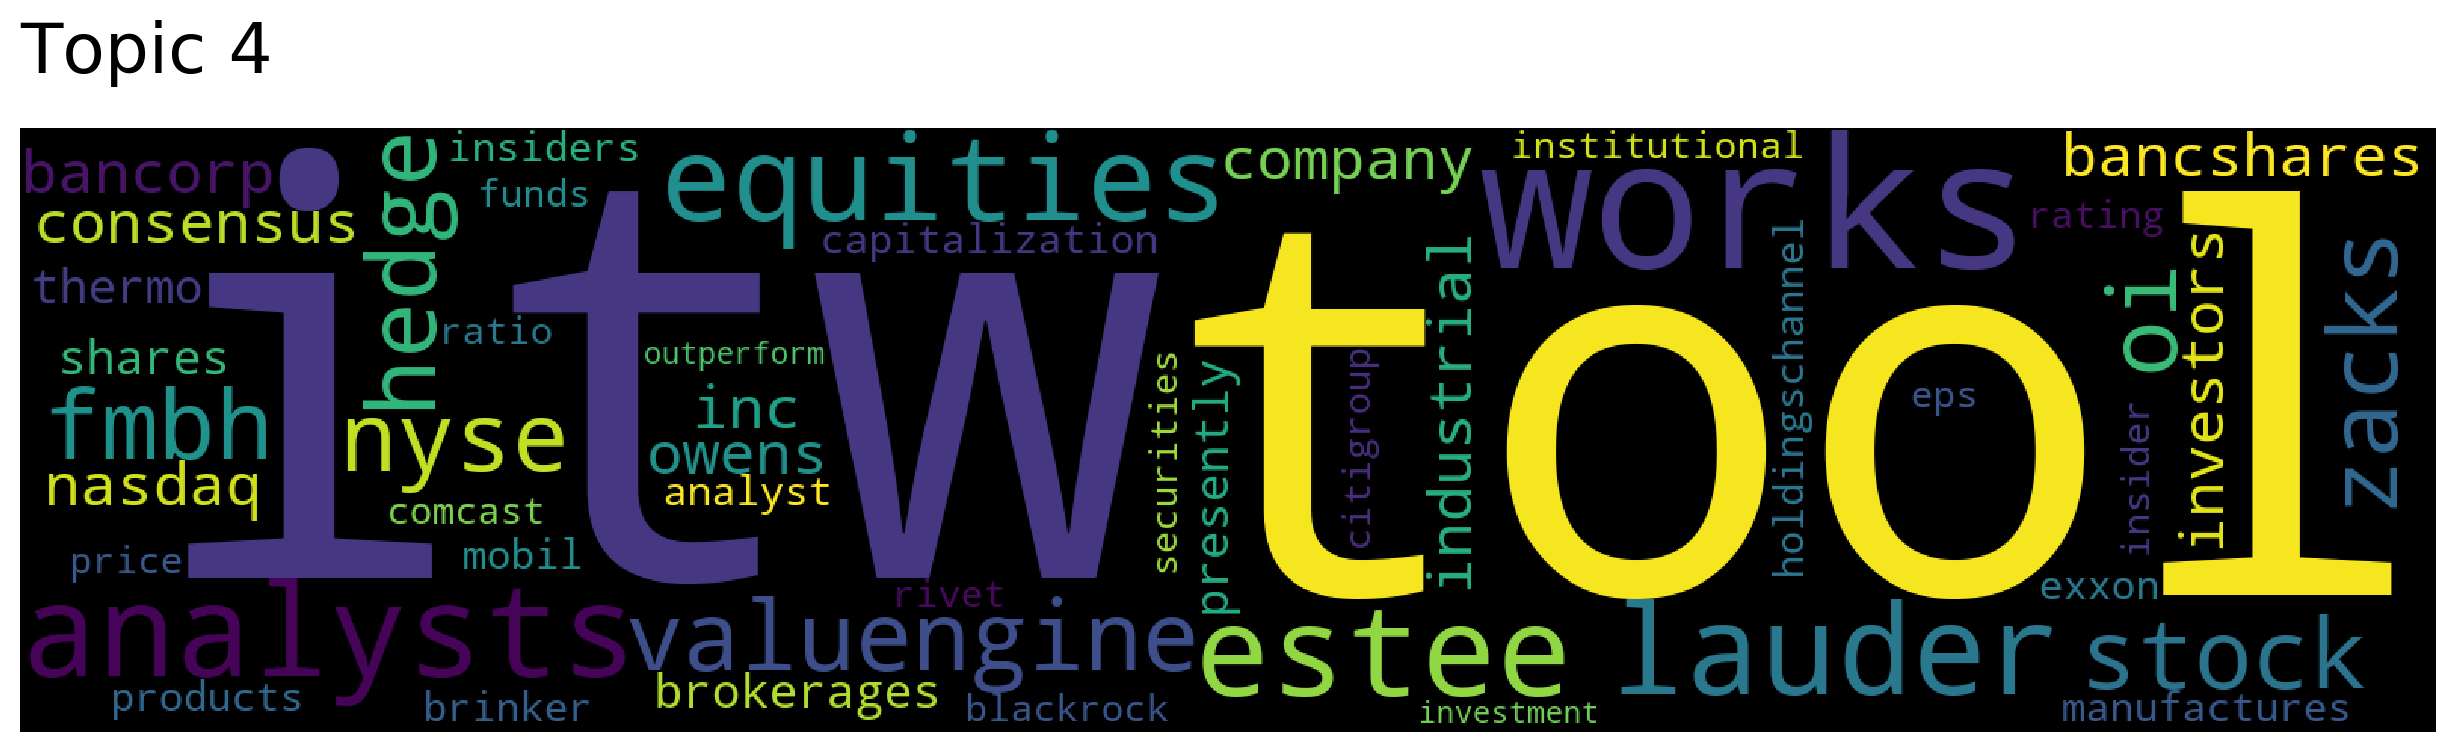

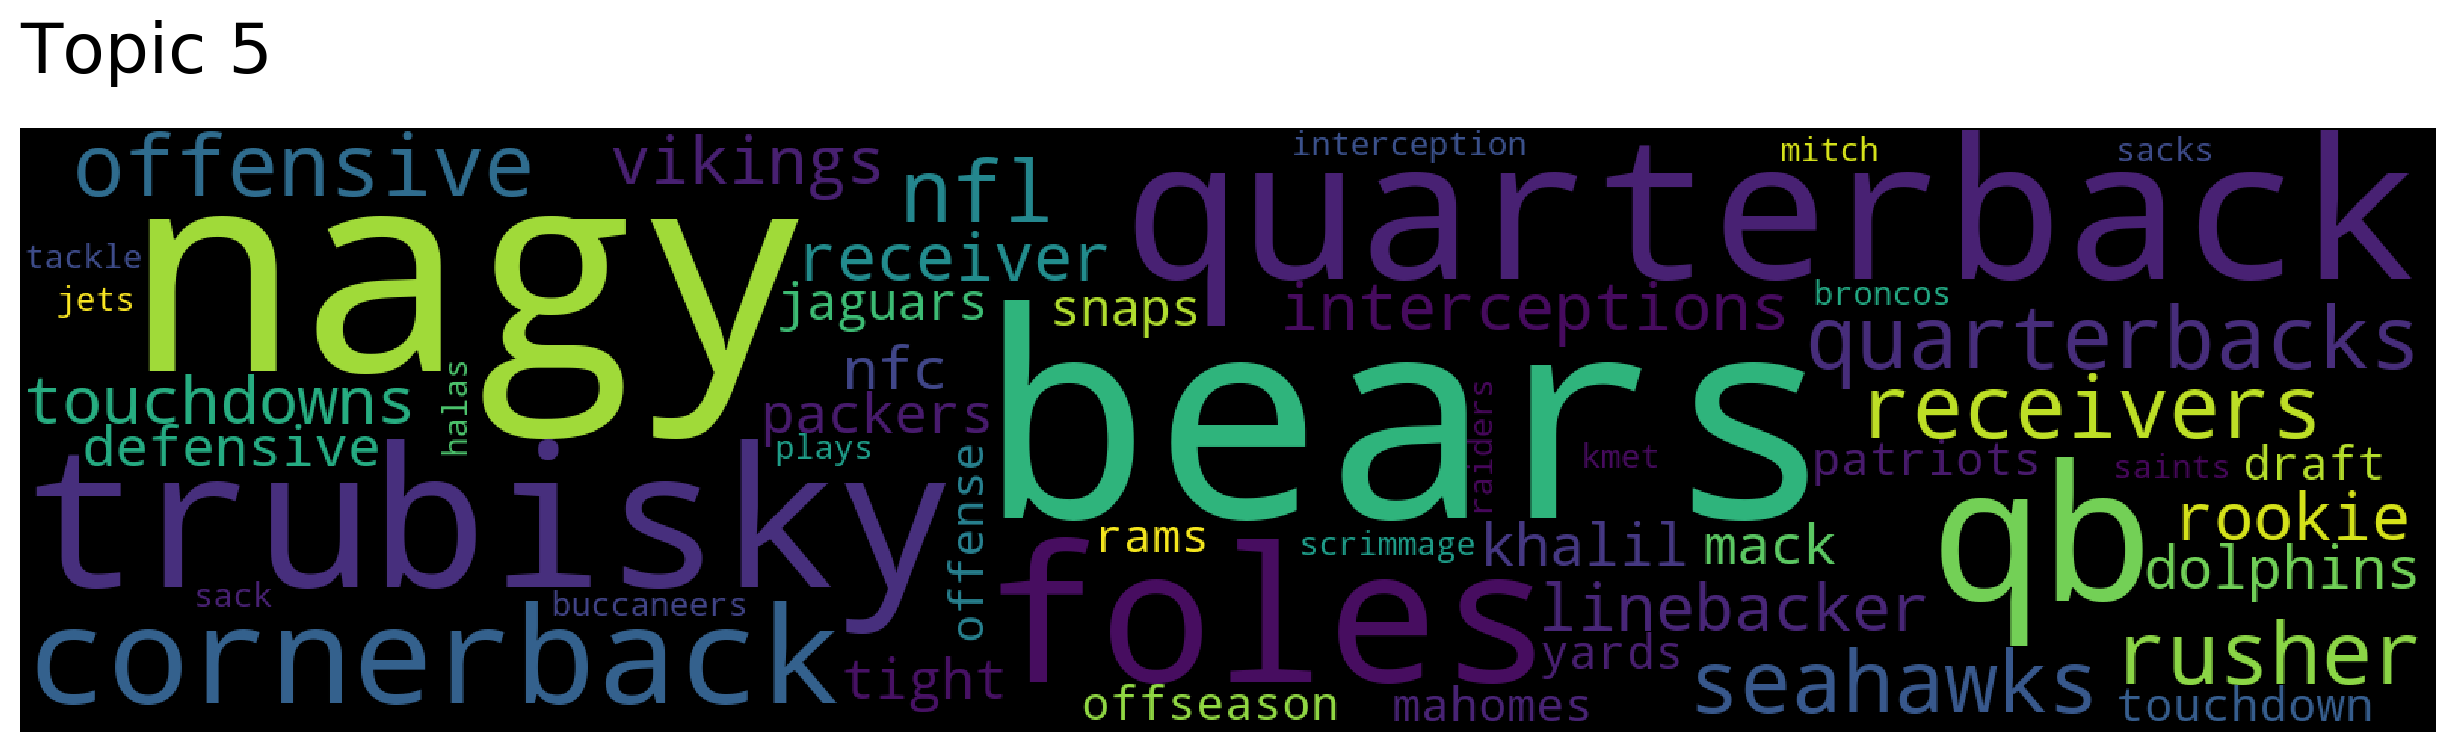

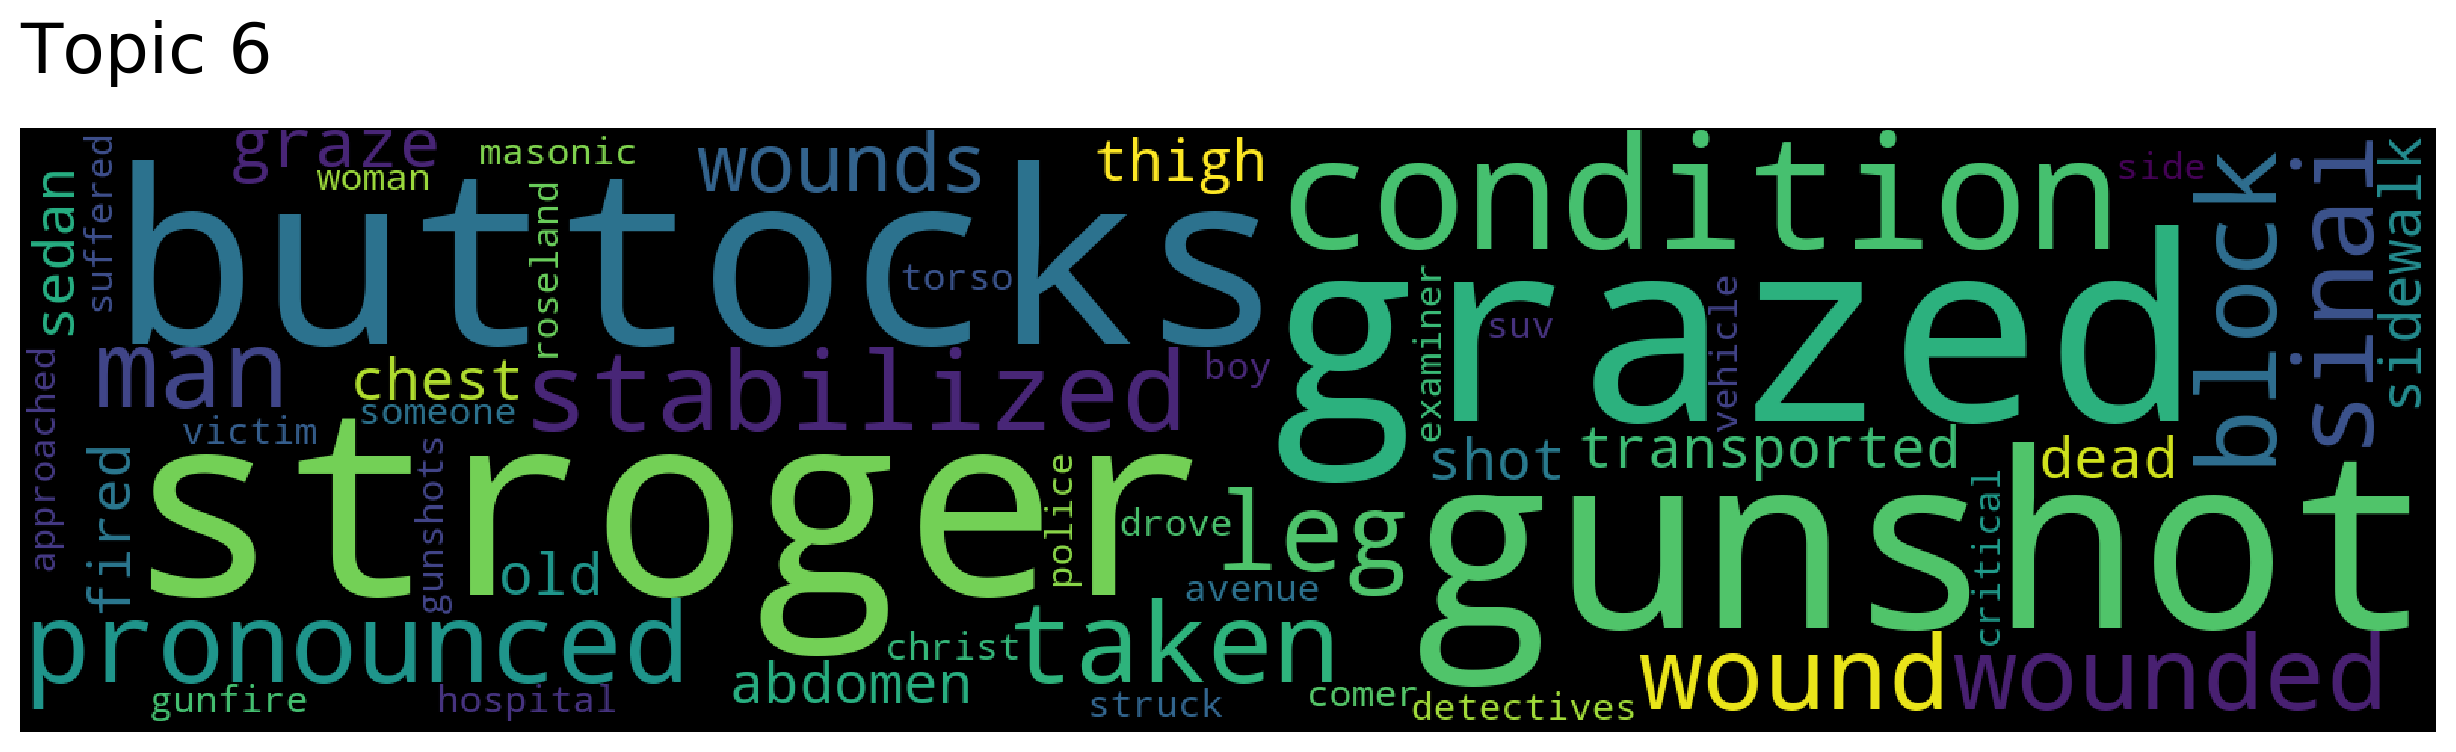

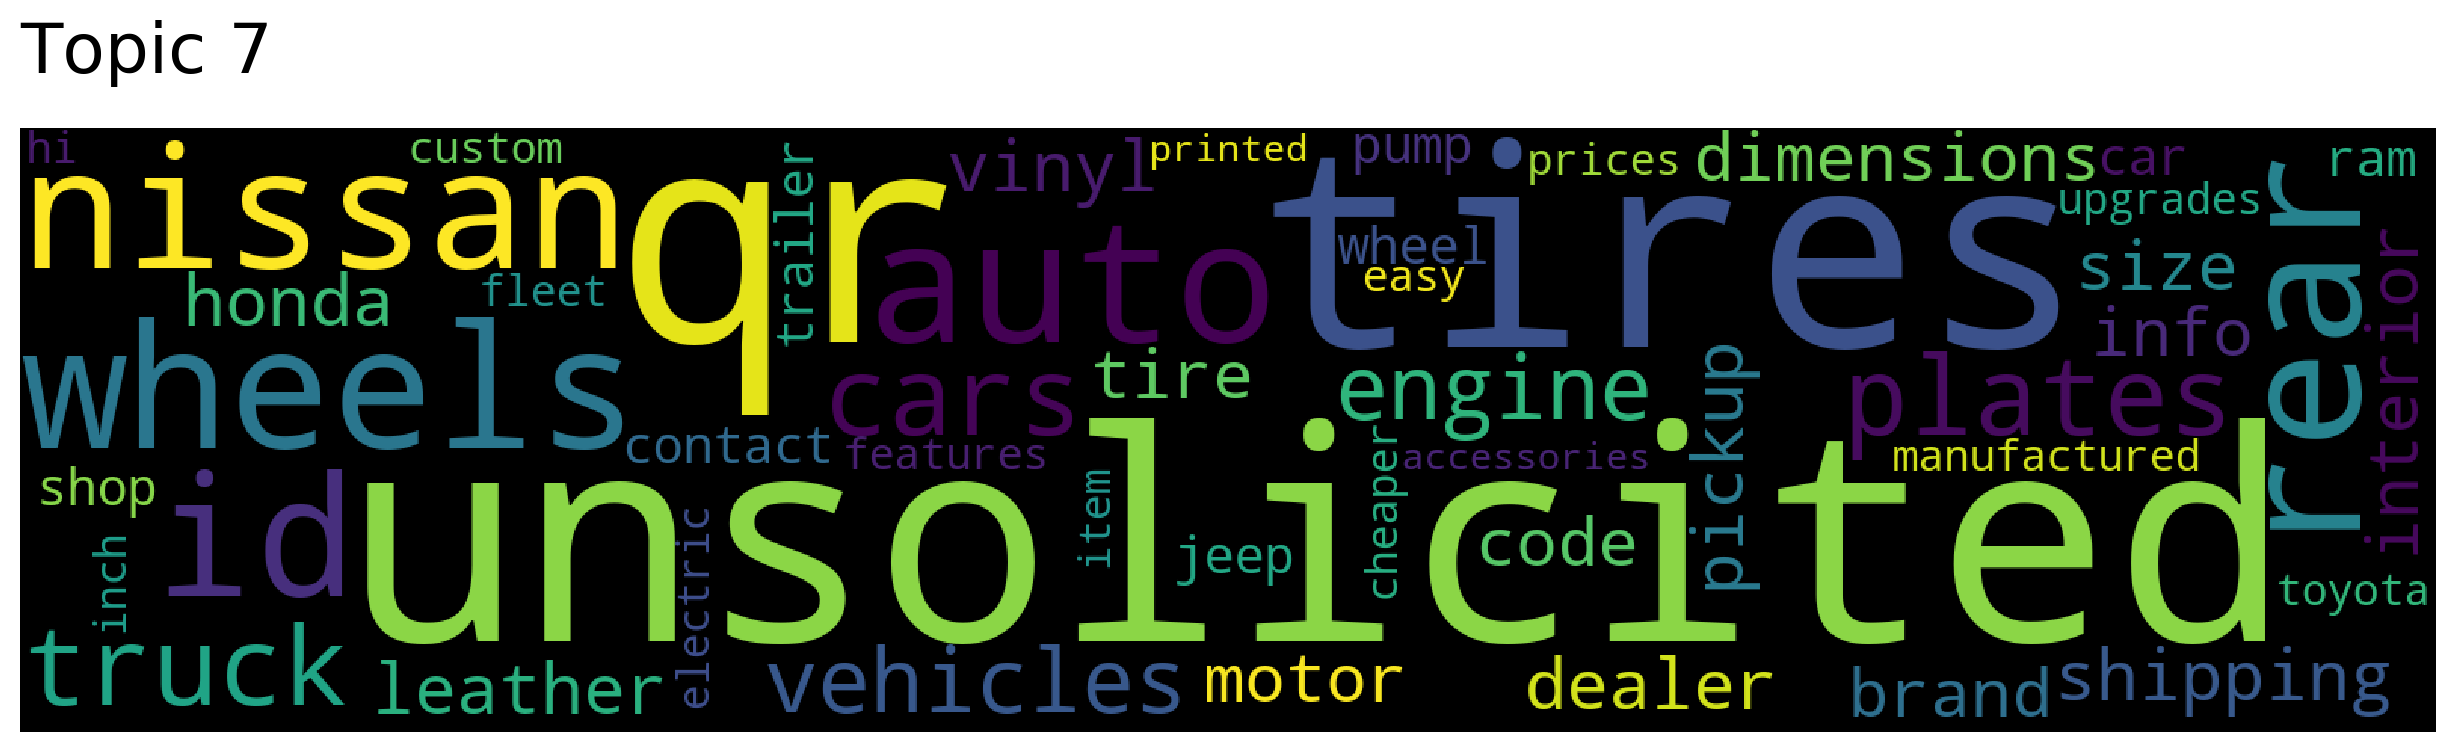

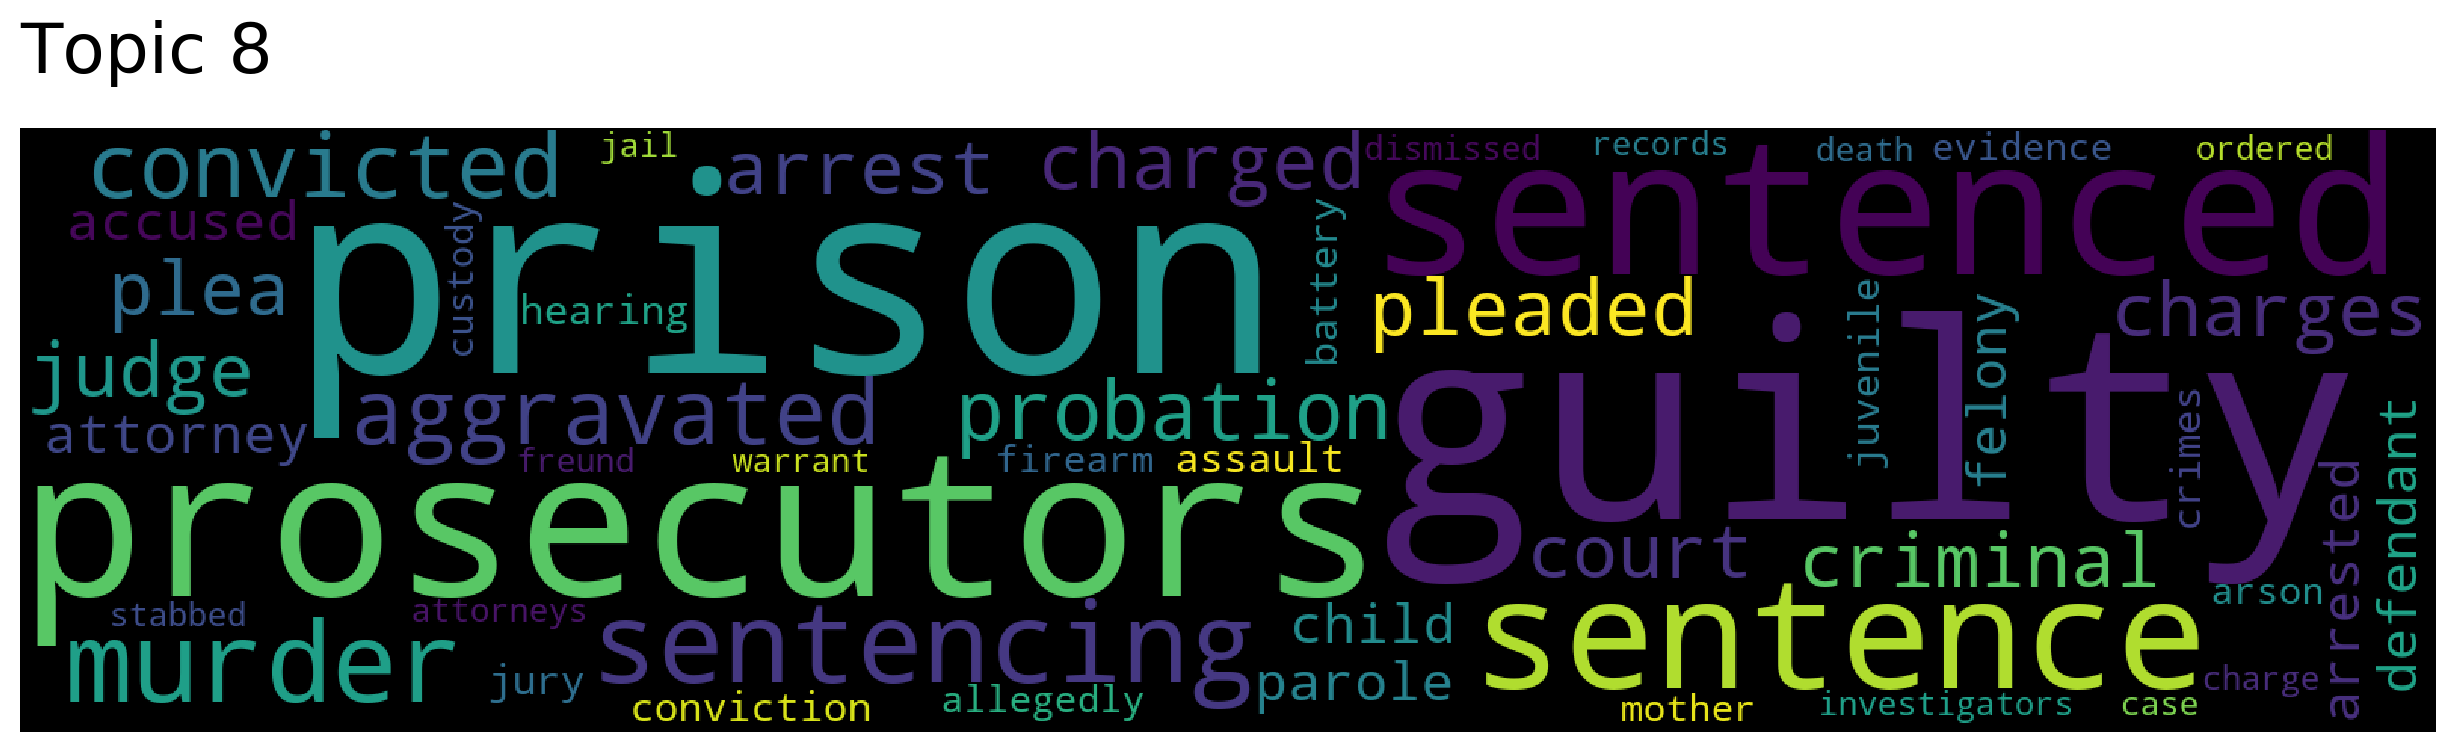

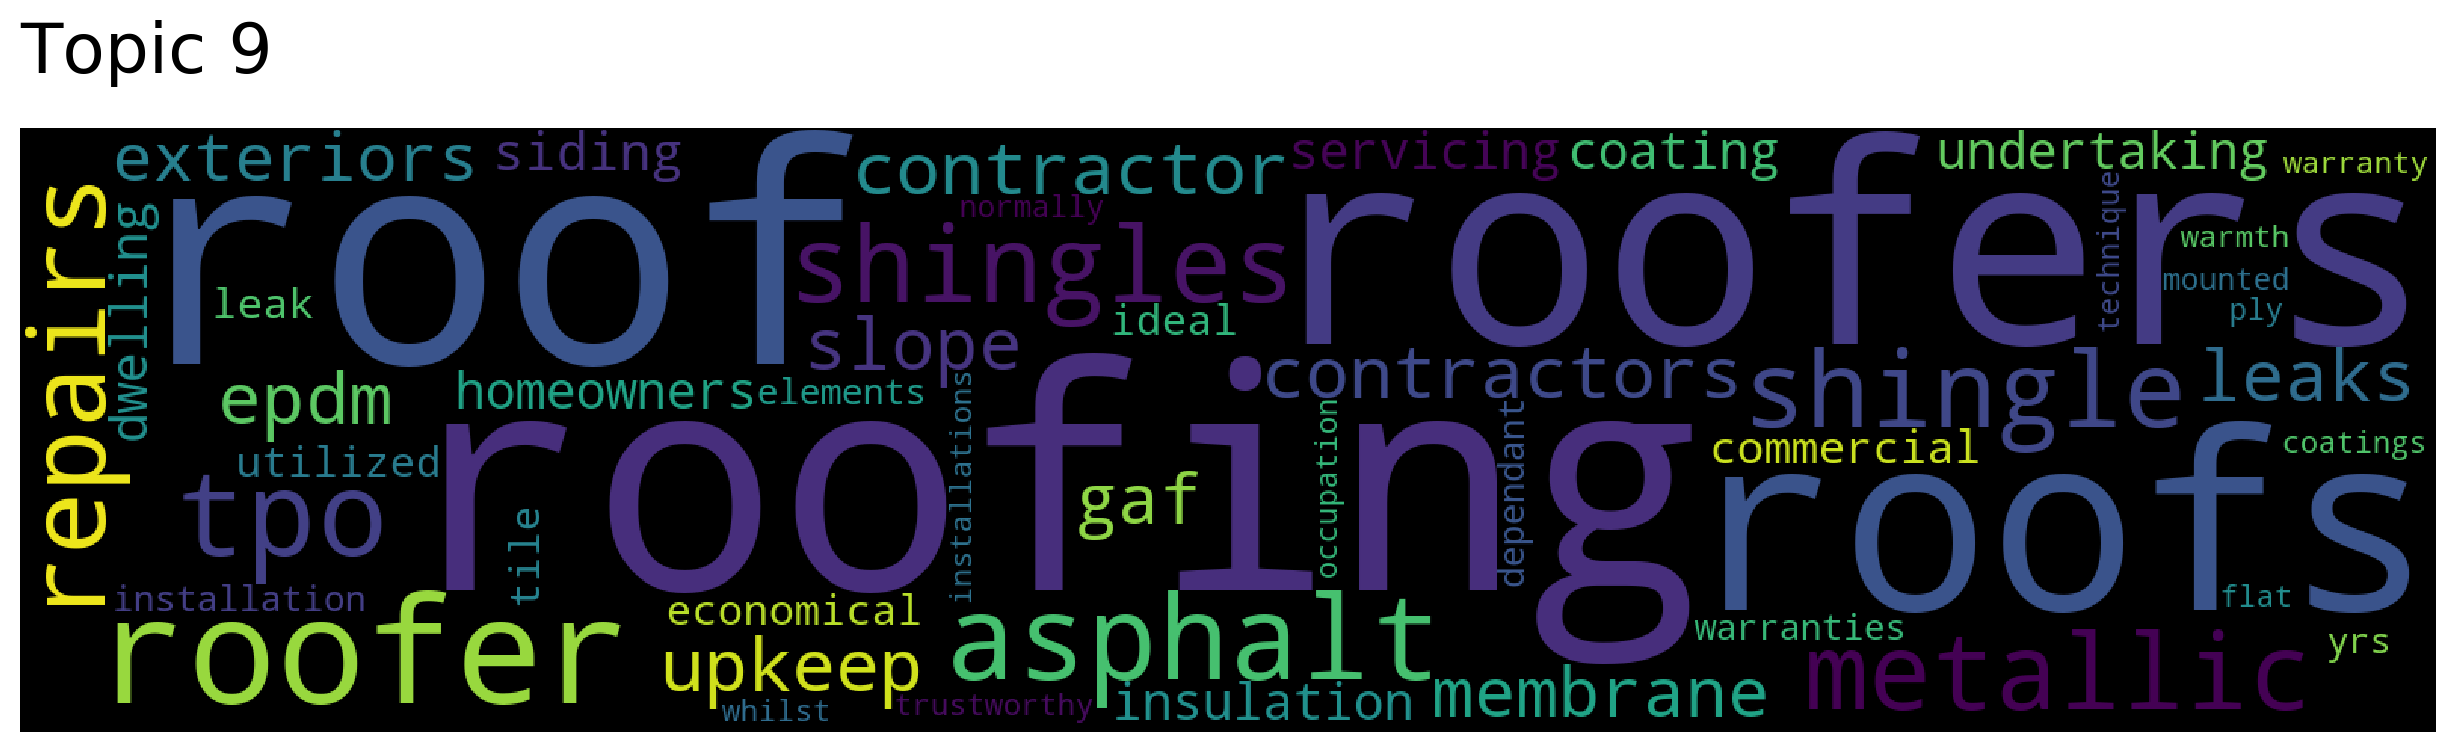

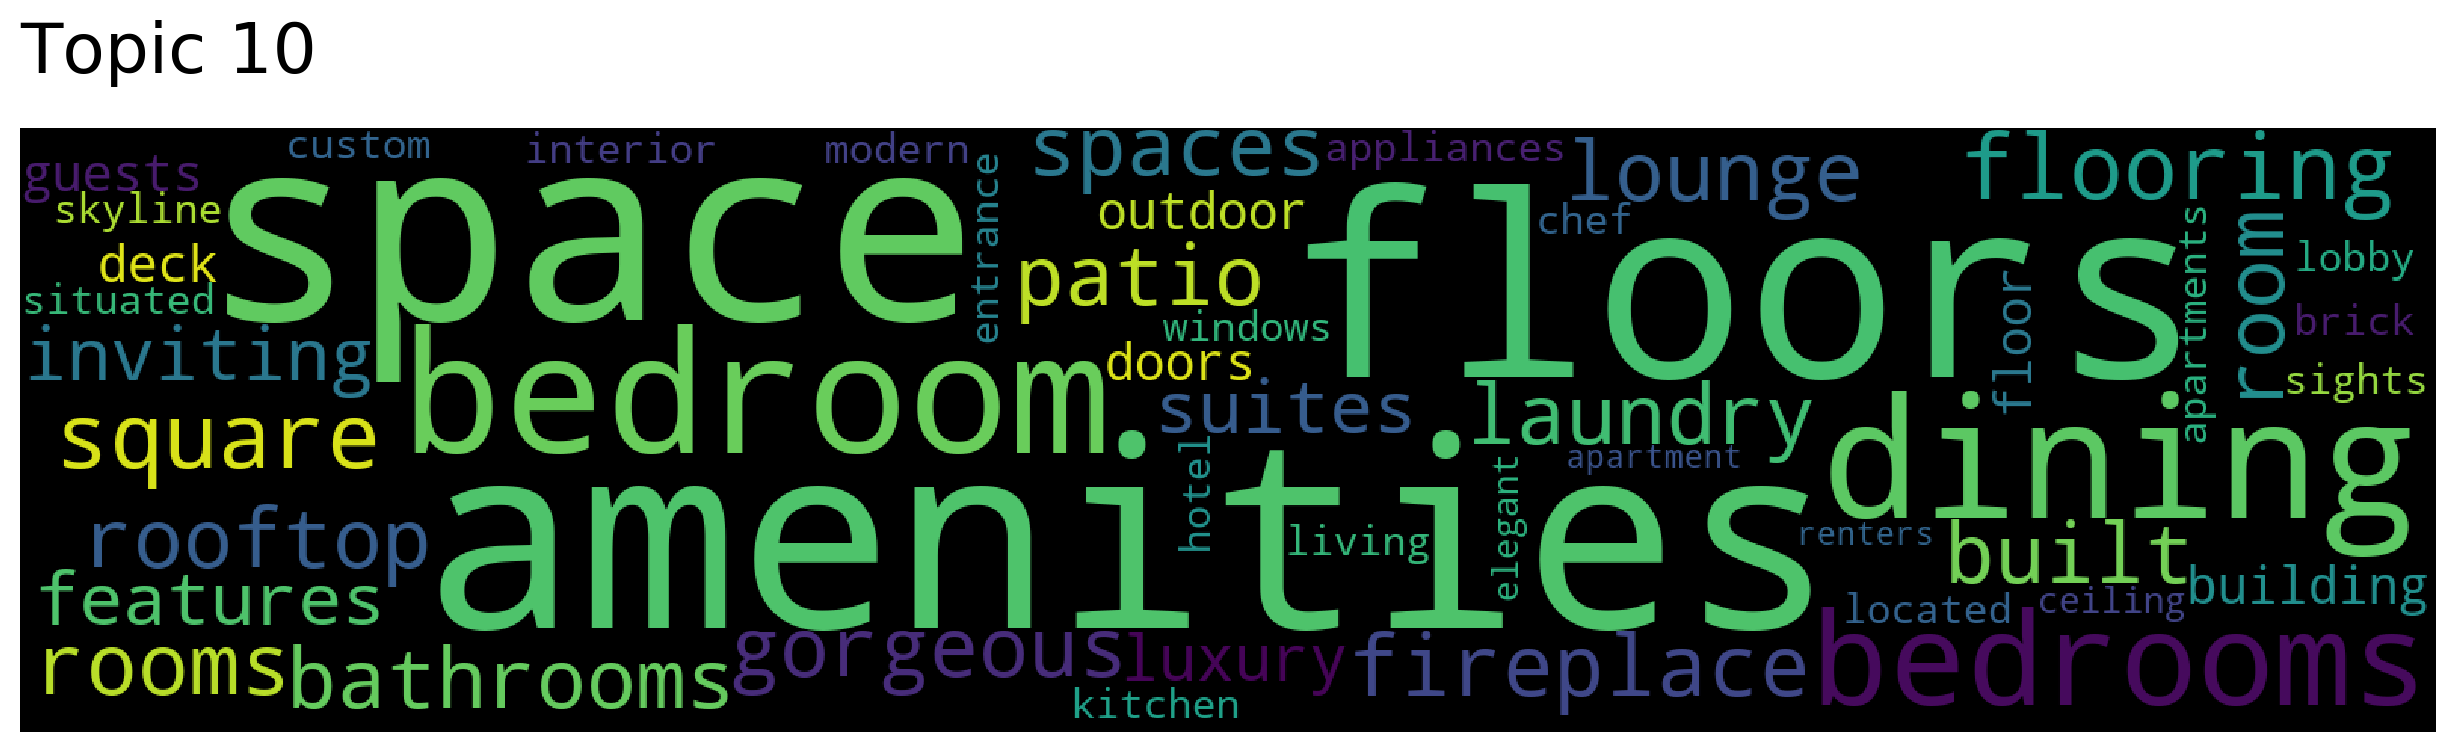

In [66]:
for topic in topic_nums[0:11]:
    t2v_model.generate_topic_wordcloud(topic, background_color="black")

In [68]:
dir(t2v_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_assign_documents_to_topic',
 '_calculate_documents_topic',
 '_calculate_topic_sizes',
 '_check_document_index_status',
 '_check_hnswlib_status',
 '_check_import_status',
 '_check_model_status',
 '_check_word_index_status',
 '_create_topic_vectors',
 '_deduplicate_topics',
 '_embed_documents',
 '_find_topic_words_and_scores',
 '_get_combined_vec',
 '_get_document_ids',
 '_get_document_indexes',
 '_get_document_vectors',
 '_get_word_vectors',
 '_index2word',
 '_l2_normalize',
 '_less_than_zero',
 '_reorder_topics',
 '_search_vectors_by_vector',
 '_set_document_vectors',
 '_unassign_documents_from_topic',
 '_validate_doc_i

In [86]:
t2v_model.get_topics()

(array([['my', 'me', 'so', ..., 'got', 'never', 'glad'],
        ['inning', 'pitcher', 'hitter', ..., 'giolito', 'bote', 'heyward'],
        ['delicious', 'menu', 'cheese', ..., 'pizzeria', 'dining',
         'roast'],
        ...,
        ['consolidated', 'unit', 'district', ..., 'elmwood', 'newark',
         'central'],
        ['breitbart', 'hawkins', 'columnist', ..., 'dead', 'mayor',
         'arrest'],
        ['supervisors', 'popcorn', 'lightfoot', ..., 'footage', 'reforms',
         'shame']], dtype='<U15'),
 array([[0.57775813, 0.53323853, 0.4945745 , ..., 0.38599   , 0.38585877,
         0.38517657],
        [0.7026348 , 0.69894046, 0.6917862 , ..., 0.54216206, 0.5408335 ,
         0.5395285 ],
        [0.7029181 , 0.6694576 , 0.6591055 , ..., 0.4818874 , 0.47904566,
         0.47893324],
        ...,
        [0.93193984, 0.9226577 , 0.9158392 , ..., 0.42882514, 0.4265193 ,
         0.42452353],
        [0.8338954 , 0.62169707, 0.5441705 , ..., 0.2578923 , 0.24892853,
       

In [93]:
t2v_model.search_documents_by_topic(topic_num=6, num_docs = 2)

(array(['(Sun Times Wire) Five people were shot Monday in Chicago, including a teen boy who was wounded by gunfire in Garfield Park on the West Side.\nThe 17-year-old was walking about 9 p.m. in the 4200 block of West West End Avenue when he heard multiple gunshots, Chicago police said. He ran away and realized he was grazed in the leg.\nHe was taken to West Suburban Medical Center in good condition, police said. He didn’t give investigators a description of the shooter.\nNo one is in custody as Area North detectives investigate.\nA 37-year-old man was wounded when he was shot by someone after an argument in Austin on the West Side.\nThe man was shot in the leg and buttocks about 1:30 p.m. in the 4800 block of West Gladys Avenue, police said. He was arguing with someone who later left. However, that person returned in a red four-door vehicle and opened fire.\nThe man was taken to Stroger Hospital in fair condition, police said.\nNo one is in custody as Area North detectives investigate

In [94]:
?t2v_model.search_documents_by_topic